# Airline Review Data Cleaning and Analysis

This notebook performs comprehensive data cleaning and exploratory analysis on airline review data.

## Install VADER for sentiment analysis

In [167]:
!pip install vaderSentiment


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Imports

In [168]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [169]:
FIG_DIR = Path("figs/airline_review")
FIG_DIR.mkdir(parents=True, exist_ok=True)

## Load Dataset

In [170]:
df = pd.read_csv("data/raw/AirlineScrappedReview_Cleaned.csv")
df.head()

,Passanger_Name,Flying_Date,Route,Rating,Verified,Review_title,Review_content,Traveller_Type,Class,Start_Location,End_Location,Layover_Route,Start_Latitude,Start_Longitude,Start_Address,End_Latitude,End_Longitude,End_Address
0,Paige Boet,June 2023,New Orleans to London,1,Trip Verified,The airline lost my luggage,The airline lost my luggage and was absolutely...,Solo Leisure,Economy Class,New Orleans,London,NaN,29.975998,-90.078213,"New Orleans, Orleans Parish, Louisiana, United...",51.507446,-0.127765,"London, Greater London, England, United Kingdom"
1,S Layne,March 2023,London to Amman,1,Trip Verified,fully refunded by our travel insurance,"We booked on the BA website, round trip flight...",Couple Leisure,Business Class,London,Amman,NaN,51.507446,-0.127765,"London, Greater London, England, United Kingdom",31.951569,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,..."
2,E Lanewoski,NaN,Heathrow to Bodrum,2,Trip Verified,no boarding drinks provided,"First time flying with BA business class, neve...",Solo Leisure,Business Class,London Heathrow,Bodrum,NaN,51.467739,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",37.034399,27.430651,"Bodrum, Muğla, Ege Bölgesi, Türkiye"
3,Joel Burman,June 2023,Amman to London,4,Not Verified,WiFi didn't work,You can buy sandwiches and crisps but don't ex...,Solo Leisure,Economy Class,Amman,London,NaN,31.951569,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,...",51.507446,-0.127765,"London, Greater London, England, United Kingdom"
4,R Vines,NaN,London City to Ibiza,7,Trip Verified,stick with economy,This is a two-for-one review covering economy ...,Family Leisure,Business Class,London City,Ibiza,NaN,42.953765,-81.229153,"London (city), Ontario, N6C 0A7, Canada",38.974390,1.419746,"Eivissa, Illes Balears, España"


In [171]:
print(df.columns)

Index(['Passanger_Name', 'Flying_Date', 'Route', 'Rating', 'Verified',
       'Review_title', 'Review_content', 'Traveller_Type', 'Class',
       'Start_Location', 'End_Location', 'Layover_Route', 'Start_Latitude',
       'Start_Longitude', 'Start_Address', 'End_Latitude', 'End_Longitude',
       'End_Address'],
      dtype='object')


In [172]:
print("Value counts for 'traveller_type' column:")
print(df['Traveller_Type'].value_counts())

Value counts for 'traveller_type' column:
Traveller_Type
Couple Leisure    949
Solo Leisure      860
Unknown           760
Business          623
Family Leisure    382
Various             1
Name: count, dtype: int64


**Observations:**
1. The dataset contains airline reviews with flight details, customer information, and review content. Notice the column names have inconsistent formatting with mixed cases and spaces.
2. We have reviews. we can do sentiment analysis on them

In [173]:
# detect and delete duplicates
print(f"Number of duplicates: {df.duplicated().sum()}")
df = df.drop_duplicates()

Number of duplicates: 74


## Initial EDA

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3501 entries, 0 to 3574
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Passanger_Name   3500 non-null   object 
 1   Flying_Date      955 non-null    object 
 2   Route            2807 non-null   object 
 3   Rating           3501 non-null   int64  
 4   Verified         3501 non-null   object 
 5   Review_title     3501 non-null   object 
 6   Review_content   3501 non-null   object 
 7   Traveller_Type   3501 non-null   object 
 8   Class            3501 non-null   object 
 9   Start_Location   2807 non-null   object 
 10  End_Location     2807 non-null   object 
 11  Layover_Route    484 non-null    object 
 12  Start_Latitude   3441 non-null   float64
 13  Start_Longitude  3441 non-null   float64
 14  Start_Address    3441 non-null   object 
 15  End_Latitude     3402 non-null   float64
 16  End_Longitude    3402 non-null   float64
 17  End_Address      34

In [175]:
df.describe()

,Rating,Start_Latitude,Start_Longitude,End_Latitude,End_Longitude
count,3501.000000,3441.000000,3441.000000,3402.000000,3402.000000
mean,4.764924,42.564281,-2.418618,40.429634,-1.353347
std,3.167312,17.193260,44.991376,18.904671,46.489936
min,1.000000,-37.666951,-123.182909,-37.814245,-123.179234
25%,2.000000,41.875562,-0.458780,38.954140,-0.458780
50%,4.000000,46.314475,-0.127765,46.314475,-0.127765
75%,8.000000,51.467739,11.048029,51.467739,11.048029
max,10.000000,65.011873,151.208285,64.145981,174.550610


## Let's normalize column names

In [176]:
def normalize_column_names(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    return df

df = normalize_column_names(df)
df.head()

,passanger_name,flying_date,route,rating,verified,review_title,review_content,traveller_type,class,start_location,end_location,layover_route,start_latitude,start_longitude,start_address,end_latitude,end_longitude,end_address
0,Paige Boet,June 2023,New Orleans to London,1,Trip Verified,The airline lost my luggage,The airline lost my luggage and was absolutely...,Solo Leisure,Economy Class,New Orleans,London,NaN,29.975998,-90.078213,"New Orleans, Orleans Parish, Louisiana, United...",51.507446,-0.127765,"London, Greater London, England, United Kingdom"
1,S Layne,March 2023,London to Amman,1,Trip Verified,fully refunded by our travel insurance,"We booked on the BA website, round trip flight...",Couple Leisure,Business Class,London,Amman,NaN,51.507446,-0.127765,"London, Greater London, England, United Kingdom",31.951569,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,..."
2,E Lanewoski,NaN,Heathrow to Bodrum,2,Trip Verified,no boarding drinks provided,"First time flying with BA business class, neve...",Solo Leisure,Business Class,London Heathrow,Bodrum,NaN,51.467739,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",37.034399,27.430651,"Bodrum, Muğla, Ege Bölgesi, Türkiye"
3,Joel Burman,June 2023,Amman to London,4,Not Verified,WiFi didn't work,You can buy sandwiches and crisps but don't ex...,Solo Leisure,Economy Class,Amman,London,NaN,31.951569,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,...",51.507446,-0.127765,"London, Greater London, England, United Kingdom"
4,R Vines,NaN,London City to Ibiza,7,Trip Verified,stick with economy,This is a two-for-one review covering economy ...,Family Leisure,Business Class,London City,Ibiza,NaN,42.953765,-81.229153,"London (city), Ontario, N6C 0A7, Canada",38.974390,1.419746,"Eivissa, Illes Balears, España"


## Check for NaNs

In [177]:
# check for nans
for col in df.columns:
  print(f'Column {col} has {df[col].isnull().sum()} / {len(df)} null values ({df[col].isnull().sum() / len(df) * 100} %)')

Column passanger_name has 1 / 3501 null values (0.028563267637817767 %)
Column flying_date has 2546 / 3501 null values (72.72207940588403 %)
Column route has 694 / 3501 null values (19.82290774064553 %)
Column rating has 0 / 3501 null values (0.0 %)
Column verified has 0 / 3501 null values (0.0 %)
Column review_title has 0 / 3501 null values (0.0 %)
Column review_content has 0 / 3501 null values (0.0 %)
Column traveller_type has 0 / 3501 null values (0.0 %)
Column class has 0 / 3501 null values (0.0 %)
Column start_location has 694 / 3501 null values (19.82290774064553 %)
Column end_location has 694 / 3501 null values (19.82290774064553 %)
Column layover_route has 3017 / 3501 null values (86.1753784632962 %)
Column start_latitude has 60 / 3501 null values (1.7137960582690661 %)
Column start_longitude has 60 / 3501 null values (1.7137960582690661 %)
Column start_address has 60 / 3501 null values (1.7137960582690661 %)
Column end_latitude has 99 / 3501 null values (2.827763496143959 %)
C

**Observation:** There seems to be an exceptionally large number of NaNs in `flying_date` and `layover_route`. `layover_route` is probably due to the fact that these routes didn't have layover. we still need to investigate `flying_date`

**NOTE:** missing values in `flying_date` can be extracted using NLP techniques as the SOME of `review_content` do contain dates but this is outside the scope of the project


In [178]:
print("Value counts for 'layover_route' column:")
print(df['layover_route'].value_counts())

Value counts for 'layover_route' column:
layover_route
London                                           197
London - Heathrow                                151
Heathrow                                          31
London Heathrow                                   21
Singapore                                         17
Singapore - Changi                                 9
Gatwick                                            6
London                                             5
Bahrain - Bahrain International Airport            3
London Heathrow                                    2
Johannesburg - OR Tambo International Airport      2
London - Gatwick                                   2
Dublin                                             1
Chicago / London                                   1
Toronto / London                                   1
London,                                            1
Los Angeles                                        1
Doha                                        

## Add sentiment analysis

In [179]:
def sentiment_scores(sentence):
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)

    if sentiment_dict['compound'] >= 0.05:
        return "positive", sentiment_dict['compound']
    elif sentiment_dict['compound'] <= -0.05:
        return "negative", sentiment_dict['compound']
    else:
        return "neutral", sentiment_dict['compound']

df['sentiment'], df['sentiment_score'] = zip(*df['review_content'].apply(lambda x: sentiment_scores(x)))
df

,passanger_name,flying_date,route,rating,verified,review_title,review_content,traveller_type,class,start_location,end_location,layover_route,start_latitude,start_longitude,start_address,end_latitude,end_longitude,end_address,sentiment,sentiment_score
0,Paige Boet,June 2023,New Orleans to London,1,Trip Verified,The airline lost my luggage,The airline lost my luggage and was absolutely...,Solo Leisure,Economy Class,New Orleans,London,NaN,29.975998,-90.078213,"New Orleans, Orleans Parish, Louisiana, United...",51.507446,-0.127765,"London, Greater London, England, United Kingdom",negative,-0.7990
1,S Layne,March 2023,London to Amman,1,Trip Verified,fully refunded by our travel insurance,"We booked on the BA website, round trip flight...",Couple Leisure,Business Class,London,Amman,NaN,51.507446,-0.127765,"London, Greater London, England, United Kingdom",31.951569,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,...",neutral,0.0219
2,E Lanewoski,NaN,Heathrow to Bodrum,2,Trip Verified,no boarding drinks provided,"First time flying with BA business class, neve...",Solo Leisure,Business Class,London Heathrow,Bodrum,NaN,51.467739,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",37.034399,27.430651,"Bodrum, Muğla, Ege Bölgesi, Türkiye",negative,-0.7096
3,Joel Burman,June 2023,Amman to London,4,Not Verified,WiFi didn't work,You can buy sandwiches and crisps but don't ex...,Solo Leisure,Economy Class,Amman,London,NaN,31.951569,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,...",51.507446,-0.127765,"London, Greater London, England, United Kingdom",negative,-0.5849
4,R Vines,NaN,London City to Ibiza,7,Trip Verified,stick with economy,This is a two-for-one review covering economy ...,Family Leisure,Business Class,London City,Ibiza,NaN,42.953765,-81.229153,"London (city), Ontario, N6C 0A7, Canada",38.974390,1.419746,"Eivissa, Illes Balears, España",positive,0.9789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3570,W Benson,NaN,NaN,4,Not Verified,British Airways customer review,LHR-HKG on Boeing 747 - 23/08/12. Much has bee...,Unknown,Economy Class,NaN,NaN,NaN,46.314475,11.048029,"Nanno, Ville d'Anaunia, Comunità della Val di ...",46.314475,11.048029,"Nanno, Ville d'Anaunia, Comunità della Val di ...",positive,0.9129
3571,S Luqman,NaN,NaN,4,Not Verified,British Airways customer review,Just got back from Bridgetown Barbados flying ...,Unknown,Economy Class,NaN,NaN,NaN,46.314475,11.048029,"Nanno, Ville d'Anaunia, Comunità della Val di ...",46.314475,11.048029,"Nanno, Ville d'Anaunia, Comunità della Val di ...",negative,-0.8763
3572,D Smith,NaN,NaN,4,Not Verified,British Airways customer review,LHR-JFK-LAX-LHR. Check in was ok apart from be...,Unknown,Economy Class,NaN,NaN,NaN,46.314475,11.048029,"Nanno, Ville d'Anaunia, Comunità della Val di ...",46.314475,11.048029,"Nanno, Ville d'Anaunia, Comunità della Val di ...",negative,-0.2003
3573,W Benson,NaN,NaN,6,Not Verified,British Airways customer review,HKG-LHR in New Club World on Boeing 777-300 - ...,Unknown,Business Class,NaN,NaN,NaN,46.314475,11.048029,"Nanno, Ville d'Anaunia, Comunità della Val di ...",46.314475,11.048029,"Nanno, Ville d'Anaunia, Comunità della Val di ...",positive,0.9864


## Fill NaN Values

### Layover:
**Strategy:** if layover is NaN, it is safe to "assume" that it is a direct flight

In [180]:
df.loc[df['layover_route'].isnull(), 'layover_route'] = 'direct_flight'
df

,passanger_name,flying_date,route,rating,verified,review_title,review_content,traveller_type,class,start_location,end_location,layover_route,start_latitude,start_longitude,start_address,end_latitude,end_longitude,end_address,sentiment,sentiment_score
0,Paige Boet,June 2023,New Orleans to London,1,Trip Verified,The airline lost my luggage,The airline lost my luggage and was absolutely...,Solo Leisure,Economy Class,New Orleans,London,direct_flight,29.975998,-90.078213,"New Orleans, Orleans Parish, Louisiana, United...",51.507446,-0.127765,"London, Greater London, England, United Kingdom",negative,-0.7990
1,S Layne,March 2023,London to Amman,1,Trip Verified,fully refunded by our travel insurance,"We booked on the BA website, round trip flight...",Couple Leisure,Business Class,London,Amman,direct_flight,51.507446,-0.127765,"London, Greater London, England, United Kingdom",31.951569,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,...",neutral,0.0219
2,E Lanewoski,NaN,Heathrow to Bodrum,2,Trip Verified,no boarding drinks provided,"First time flying with BA business class, neve...",Solo Leisure,Business Class,London Heathrow,Bodrum,direct_flight,51.467739,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",37.034399,27.430651,"Bodrum, Muğla, Ege Bölgesi, Türkiye",negative,-0.7096
3,Joel Burman,June 2023,Amman to London,4,Not Verified,WiFi didn't work,You can buy sandwiches and crisps but don't ex...,Solo Leisure,Economy Class,Amman,London,direct_flight,31.951569,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,...",51.507446,-0.127765,"London, Greater London, England, United Kingdom",negative,-0.5849
4,R Vines,NaN,London City to Ibiza,7,Trip Verified,stick with economy,This is a two-for-one review covering economy ...,Family Leisure,Business Class,London City,Ibiza,direct_flight,42.953765,-81.229153,"London (city), Ontario, N6C 0A7, Canada",38.974390,1.419746,"Eivissa, Illes Balears, España",positive,0.9789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3570,W Benson,NaN,NaN,4,Not Verified,British Airways customer review,LHR-HKG on Boeing 747 - 23/08/12. Much has bee...,Unknown,Economy Class,NaN,NaN,direct_flight,46.314475,11.048029,"Nanno, Ville d'Anaunia, Comunità della Val di ...",46.314475,11.048029,"Nanno, Ville d'Anaunia, Comunità della Val di ...",positive,0.9129
3571,S Luqman,NaN,NaN,4,Not Verified,British Airways customer review,Just got back from Bridgetown Barbados flying ...,Unknown,Economy Class,NaN,NaN,direct_flight,46.314475,11.048029,"Nanno, Ville d'Anaunia, Comunità della Val di ...",46.314475,11.048029,"Nanno, Ville d'Anaunia, Comunità della Val di ...",negative,-0.8763
3572,D Smith,NaN,NaN,4,Not Verified,British Airways customer review,LHR-JFK-LAX-LHR. Check in was ok apart from be...,Unknown,Economy Class,NaN,NaN,direct_flight,46.314475,11.048029,"Nanno, Ville d'Anaunia, Comunità della Val di ...",46.314475,11.048029,"Nanno, Ville d'Anaunia, Comunità della Val di ...",negative,-0.2003
3573,W Benson,NaN,NaN,6,Not Verified,British Airways customer review,HKG-LHR in New Club World on Boeing 777-300 - ...,Unknown,Business Class,NaN,NaN,direct_flight,46.314475,11.048029,"Nanno, Ville d'Anaunia, Comunità della Val di ...",46.314475,11.048029,"Nanno, Ville d'Anaunia, Comunità della Val di ...",positive,0.9864


In [181]:
# check for nans
for col in df.columns:
  print(f'Column {col} has {df[col].isnull().sum()} / {len(df)} null values')

Column passanger_name has 1 / 3501 null values
Column flying_date has 2546 / 3501 null values
Column route has 694 / 3501 null values
Column rating has 0 / 3501 null values
Column verified has 0 / 3501 null values
Column review_title has 0 / 3501 null values
Column review_content has 0 / 3501 null values
Column traveller_type has 0 / 3501 null values
Column class has 0 / 3501 null values
Column start_location has 694 / 3501 null values
Column end_location has 694 / 3501 null values
Column layover_route has 0 / 3501 null values
Column start_latitude has 60 / 3501 null values
Column start_longitude has 60 / 3501 null values
Column start_address has 60 / 3501 null values
Column end_latitude has 99 / 3501 null values
Column end_longitude has 99 / 3501 null values
Column end_address has 99 / 3501 null values
Column sentiment has 0 / 3501 null values
Column sentiment_score has 0 / 3501 null values


### Start Latitude
**Strategy:** We can look for another flight that had the same exact start address and take its `start_latitude` OR we can look for another flight that has the same exact end address and take its `end_latitude`

In [182]:
df[df['start_latitude'].isnull()]

,passanger_name,flying_date,route,rating,verified,review_title,review_content,traveller_type,class,start_location,end_location,layover_route,start_latitude,start_longitude,start_address,end_latitude,end_longitude,end_address,sentiment,sentiment_score
1019,Roger Stone,NaN,HKG to LHR,8,Trip Verified,an enjoyable experience,I thought it time BA deserved some compliments...,Business,Premium Economy,Hong Kong - International Airport (HKIA),London Heathrow,direct_flight,NaN,NaN,NaN,51.467739,-0.458780,"London Heathrow Airport, Northern Perimeter Ro...",positive,0.9910
1168,Carlos Arenas,NaN,Edimbourgh to London Gatwick,3,Trip Verified,I end up with mix feelings,I have traveled several times with British Air...,Couple Leisure,Economy Class,Edimbourgh,London Gatwick,direct_flight,NaN,NaN,NaN,51.154108,-0.182312,"London Gatwick Airport, Perimeter Road East, L...",positive,0.9809
1360,John Barry,NaN,Zakinthos to London Heathrow,8,Not Verified,very good flight again,Verified Review Zakinthos to London Heathrow...,Family Leisure,Business Class,Zakinthos,London Heathrow,direct_flight,NaN,NaN,NaN,51.467739,-0.458780,"London Heathrow Airport, Northern Perimeter Ro...",positive,0.5327
1737,Vincent Borlaug,NaN,IAD to BCN via LHR,10,Not Verified,still my first choice,Verified Review Washington to Barcelona retu...,Solo Leisure,Premium Economy,Washington DC - Dulles International,Barcelona,London - Heathrow,NaN,NaN,NaN,41.382894,2.177432,"Barcelona, Barcelonès, Barcelona, Catalunya, 0...",positive,0.8947
1749,J Hicklin,NaN,SFO to JNB via LHR,6,Not Verified,as different as night and day,Verified Review San Francisco to Johannesbur...,Solo Leisure,Business Class,"San Francisco - International Airport, SA",Johannesburg - OR Tambo International Airport,London - Heathrow,NaN,NaN,NaN,-26.136013,28.244977,"O.R. Tambo International Airport, Elgin Street...",positive,0.9922
1800,A Hillier,NaN,FRA to CPT via LHR,7,Not Verified,a dirty seat and cabin,Frankfurt to Cape Town via London Heathrow. Th...,Couple Leisure,Business Class,Frankfurt/Main - Frankfurt Airport (Rhein-Main...,Cape Town - Cape Town International Airport,London - Heathrow,NaN,NaN,NaN,-33.971846,18.602113,"Cape Town International Airport, Gousblom Cres...",positive,0.9527
1801,P Greeson,NaN,BWI to LHR,1,Not Verified,no customer loyalty sought,Verified Review Baltimore Washington to Lond...,Couple Leisure,Economy Class,Washington DC - Baltimore Washington Internati...,London Heathrow,direct_flight,NaN,NaN,NaN,51.467739,-0.458780,"London Heathrow Airport, Northern Perimeter Ro...",negative,-0.9525
1814,Natalie Tan,NaN,HKG to LHR,7,Not Verified,food was miserable,Verified Review Hong Kong to London. First ti...,Solo Leisure,Economy Class,Hong Kong - International Airport (HKIA),London Heathrow,direct_flight,NaN,NaN,NaN,51.467739,-0.458780,"London Heathrow Airport, Northern Perimeter Ro...",positive,0.2681
1816,R Prakash,December 2016,IAD to DEL via LHR,4,Not Verified,quality and quantity was extremely poor,Verified Review Disappointed. Almost all oth...,Couple Leisure,Economy Class,Washington DC - Dulles International,Delhi - Indira Gandhi International Airport,London - Heathrow,NaN,NaN,NaN,28.555168,77.084737,"Indira Gandhi International Airport, Dwarka-Pa...",positive,0.2073
1817,A Hudson,December 2016,SAN to SVQ via LHR,1,Not Verified,a cheap airline that cannot be relied on,Verified Review British Airways was known to...,Business,Premium Economy,San Diego - Lindberg Field International (CA),Sevilla,London - Heathrow,NaN,NaN,NaN,37.388630,-5.995340,"Sevilla, Andalucía, España",negative,-0.9484


In [183]:

df['start_latitude'] = df['start_latitude'].fillna(df.groupby('start_location')['start_latitude'].transform('first'))
df['start_latitude'] = df['start_latitude'].fillna(df.groupby('end_location')['end_latitude'].transform('first'))
df[df['start_latitude'].isnull()]

,passanger_name,flying_date,route,rating,verified,review_title,review_content,traveller_type,class,start_location,end_location,layover_route,start_latitude,start_longitude,start_address,end_latitude,end_longitude,end_address,sentiment,sentiment_score


### Start Longitude
**Strategy:** Same strategy as with `start_latitude`

In [184]:
df[df['start_longitude'].isnull()]

,passanger_name,flying_date,route,rating,verified,review_title,review_content,traveller_type,class,start_location,end_location,layover_route,start_latitude,start_longitude,start_address,end_latitude,end_longitude,end_address,sentiment,sentiment_score
1019,Roger Stone,NaN,HKG to LHR,8,Trip Verified,an enjoyable experience,I thought it time BA deserved some compliments...,Business,Premium Economy,Hong Kong - International Airport (HKIA),London Heathrow,direct_flight,51.467739,NaN,NaN,51.467739,-0.458780,"London Heathrow Airport, Northern Perimeter Ro...",positive,0.9910
1168,Carlos Arenas,NaN,Edimbourgh to London Gatwick,3,Trip Verified,I end up with mix feelings,I have traveled several times with British Air...,Couple Leisure,Economy Class,Edimbourgh,London Gatwick,direct_flight,51.154108,NaN,NaN,51.154108,-0.182312,"London Gatwick Airport, Perimeter Road East, L...",positive,0.9809
1360,John Barry,NaN,Zakinthos to London Heathrow,8,Not Verified,very good flight again,Verified Review Zakinthos to London Heathrow...,Family Leisure,Business Class,Zakinthos,London Heathrow,direct_flight,51.467739,NaN,NaN,51.467739,-0.458780,"London Heathrow Airport, Northern Perimeter Ro...",positive,0.5327
1737,Vincent Borlaug,NaN,IAD to BCN via LHR,10,Not Verified,still my first choice,Verified Review Washington to Barcelona retu...,Solo Leisure,Premium Economy,Washington DC - Dulles International,Barcelona,London - Heathrow,41.382894,NaN,NaN,41.382894,2.177432,"Barcelona, Barcelonès, Barcelona, Catalunya, 0...",positive,0.8947
1749,J Hicklin,NaN,SFO to JNB via LHR,6,Not Verified,as different as night and day,Verified Review San Francisco to Johannesbur...,Solo Leisure,Business Class,"San Francisco - International Airport, SA",Johannesburg - OR Tambo International Airport,London - Heathrow,-26.136013,NaN,NaN,-26.136013,28.244977,"O.R. Tambo International Airport, Elgin Street...",positive,0.9922
1800,A Hillier,NaN,FRA to CPT via LHR,7,Not Verified,a dirty seat and cabin,Frankfurt to Cape Town via London Heathrow. Th...,Couple Leisure,Business Class,Frankfurt/Main - Frankfurt Airport (Rhein-Main...,Cape Town - Cape Town International Airport,London - Heathrow,-33.971846,NaN,NaN,-33.971846,18.602113,"Cape Town International Airport, Gousblom Cres...",positive,0.9527
1801,P Greeson,NaN,BWI to LHR,1,Not Verified,no customer loyalty sought,Verified Review Baltimore Washington to Lond...,Couple Leisure,Economy Class,Washington DC - Baltimore Washington Internati...,London Heathrow,direct_flight,51.467739,NaN,NaN,51.467739,-0.458780,"London Heathrow Airport, Northern Perimeter Ro...",negative,-0.9525
1814,Natalie Tan,NaN,HKG to LHR,7,Not Verified,food was miserable,Verified Review Hong Kong to London. First ti...,Solo Leisure,Economy Class,Hong Kong - International Airport (HKIA),London Heathrow,direct_flight,51.467739,NaN,NaN,51.467739,-0.458780,"London Heathrow Airport, Northern Perimeter Ro...",positive,0.2681
1816,R Prakash,December 2016,IAD to DEL via LHR,4,Not Verified,quality and quantity was extremely poor,Verified Review Disappointed. Almost all oth...,Couple Leisure,Economy Class,Washington DC - Dulles International,Delhi - Indira Gandhi International Airport,London - Heathrow,28.555168,NaN,NaN,28.555168,77.084737,"Indira Gandhi International Airport, Dwarka-Pa...",positive,0.2073
1817,A Hudson,December 2016,SAN to SVQ via LHR,1,Not Verified,a cheap airline that cannot be relied on,Verified Review British Airways was known to...,Business,Premium Economy,San Diego - Lindberg Field International (CA),Sevilla,London - Heathrow,37.388630,NaN,NaN,37.388630,-5.995340,"Sevilla, Andalucía, España",negative,-0.9484


In [185]:
# fill in where `start_longitude` by checking which rows have the same `start_location` or `end_location` and use that value
df['start_longitude'] = df['start_longitude'].fillna(df.groupby('start_location')['start_longitude'].transform('first'))
df['start_longitude'] = df['start_longitude'].fillna(df.groupby('end_location')['end_longitude'].transform('first'))
df[df['start_longitude'].isnull()]


,passanger_name,flying_date,route,rating,verified,review_title,review_content,traveller_type,class,start_location,end_location,layover_route,start_latitude,start_longitude,start_address,end_latitude,end_longitude,end_address,sentiment,sentiment_score


### Start Address
**Strategy:** Same strategy as with `start_latitude`

In [186]:
df[df['start_address'].isnull()]

,passanger_name,flying_date,route,rating,verified,review_title,review_content,traveller_type,class,start_location,end_location,layover_route,start_latitude,start_longitude,start_address,end_latitude,end_longitude,end_address,sentiment,sentiment_score
1019,Roger Stone,NaN,HKG to LHR,8,Trip Verified,an enjoyable experience,I thought it time BA deserved some compliments...,Business,Premium Economy,Hong Kong - International Airport (HKIA),London Heathrow,direct_flight,51.467739,-0.458780,NaN,51.467739,-0.458780,"London Heathrow Airport, Northern Perimeter Ro...",positive,0.9910
1168,Carlos Arenas,NaN,Edimbourgh to London Gatwick,3,Trip Verified,I end up with mix feelings,I have traveled several times with British Air...,Couple Leisure,Economy Class,Edimbourgh,London Gatwick,direct_flight,51.154108,-0.182312,NaN,51.154108,-0.182312,"London Gatwick Airport, Perimeter Road East, L...",positive,0.9809
1360,John Barry,NaN,Zakinthos to London Heathrow,8,Not Verified,very good flight again,Verified Review Zakinthos to London Heathrow...,Family Leisure,Business Class,Zakinthos,London Heathrow,direct_flight,51.467739,-0.458780,NaN,51.467739,-0.458780,"London Heathrow Airport, Northern Perimeter Ro...",positive,0.5327
1737,Vincent Borlaug,NaN,IAD to BCN via LHR,10,Not Verified,still my first choice,Verified Review Washington to Barcelona retu...,Solo Leisure,Premium Economy,Washington DC - Dulles International,Barcelona,London - Heathrow,41.382894,2.177432,NaN,41.382894,2.177432,"Barcelona, Barcelonès, Barcelona, Catalunya, 0...",positive,0.8947
1749,J Hicklin,NaN,SFO to JNB via LHR,6,Not Verified,as different as night and day,Verified Review San Francisco to Johannesbur...,Solo Leisure,Business Class,"San Francisco - International Airport, SA",Johannesburg - OR Tambo International Airport,London - Heathrow,-26.136013,28.244977,NaN,-26.136013,28.244977,"O.R. Tambo International Airport, Elgin Street...",positive,0.9922
1800,A Hillier,NaN,FRA to CPT via LHR,7,Not Verified,a dirty seat and cabin,Frankfurt to Cape Town via London Heathrow. Th...,Couple Leisure,Business Class,Frankfurt/Main - Frankfurt Airport (Rhein-Main...,Cape Town - Cape Town International Airport,London - Heathrow,-33.971846,18.602113,NaN,-33.971846,18.602113,"Cape Town International Airport, Gousblom Cres...",positive,0.9527
1801,P Greeson,NaN,BWI to LHR,1,Not Verified,no customer loyalty sought,Verified Review Baltimore Washington to Lond...,Couple Leisure,Economy Class,Washington DC - Baltimore Washington Internati...,London Heathrow,direct_flight,51.467739,-0.458780,NaN,51.467739,-0.458780,"London Heathrow Airport, Northern Perimeter Ro...",negative,-0.9525
1814,Natalie Tan,NaN,HKG to LHR,7,Not Verified,food was miserable,Verified Review Hong Kong to London. First ti...,Solo Leisure,Economy Class,Hong Kong - International Airport (HKIA),London Heathrow,direct_flight,51.467739,-0.458780,NaN,51.467739,-0.458780,"London Heathrow Airport, Northern Perimeter Ro...",positive,0.2681
1816,R Prakash,December 2016,IAD to DEL via LHR,4,Not Verified,quality and quantity was extremely poor,Verified Review Disappointed. Almost all oth...,Couple Leisure,Economy Class,Washington DC - Dulles International,Delhi - Indira Gandhi International Airport,London - Heathrow,28.555168,77.084737,NaN,28.555168,77.084737,"Indira Gandhi International Airport, Dwarka-Pa...",positive,0.2073
1817,A Hudson,December 2016,SAN to SVQ via LHR,1,Not Verified,a cheap airline that cannot be relied on,Verified Review British Airways was known to...,Business,Premium Economy,San Diego - Lindberg Field International (CA),Sevilla,London - Heathrow,37.388630,-5.995340,NaN,37.388630,-5.995340,"Sevilla, Andalucía, España",negative,-0.9484


In [187]:
# fill in where `start_address` by checking which rows have the same `start_location` or `end_location` and use that value
df['start_address'] = df['start_address'].fillna(df.groupby('start_location')['start_address'].transform('first'))
df['start_address'] = df['start_address'].fillna(df.groupby('end_location')['end_address'].transform('first'))
df[df['start_address'].isnull()]


,passanger_name,flying_date,route,rating,verified,review_title,review_content,traveller_type,class,start_location,end_location,layover_route,start_latitude,start_longitude,start_address,end_latitude,end_longitude,end_address,sentiment,sentiment_score


### End Latitude
**Strategy:** Same strategy as with `start_latitude`

In [188]:
# drop travelle_type == 'Unknonw'

In [189]:
df[df['end_latitude'].isnull()]

,passanger_name,flying_date,route,rating,verified,review_title,review_content,traveller_type,class,start_location,end_location,layover_route,start_latitude,start_longitude,start_address,end_latitude,end_longitude,end_address,sentiment,sentiment_score
357,J Prescott,NaN,Dubai to London Heaathrow,6,Trip Verified,just used the new Club World,We've just used the new Club World for the fir...,Couple Leisure,Business Class,Dubai,London Heaathrow,direct_flight,25.265347,55.292491,"دبي, الإمارات العربية المتحدة",NaN,NaN,NaN,positive,0.8553
575,A Maharif,NaN,doha to londonDoha to London,9,Trip Verified,Surprisingly good flight,"Doha to London. Surprisingly good flight, onti...",Family Leisure,Economy Class,doha,londonDoha,direct_flight,25.285633,51.526416,"الدوحة, قطر",NaN,NaN,NaN,positive,0.9196
1074,Wolfgang Bernhart,May 2018,Frankfurt to London Cuty,1,Trip Verified,There is not a hotline,When I checked in the evening before for the 7...,Business,Economy Class,Frankfurt,London Cuty,direct_flight,50.110644,8.682092,"Frankfurt am Main, Hessen, Deutschland",NaN,NaN,NaN,positive,0.1280
1363,John Barry,NaN,London Heathrow to Zakinthos,9,Not Verified,kind and chatty with us,Verified Review London Heathrow to Zakinthos...,Family Leisure,Business Class,London Heathrow,Zakinthos,direct_flight,51.467739,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",NaN,NaN,NaN,positive,0.9814
1652,Ron Baker,NaN,LHR to GVA,2,Not Verified,not what one expects from Business Class,Verified Review Flew from London Heathrow to...,Couple Leisure,Business Class,London Heathrow,Geneva - Geneva-Cointrin International Airport,direct_flight,51.467739,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",NaN,NaN,NaN,positive,0.7090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2732,Edwin Ng,NaN,London to Singapire,6,Not Verified,British Airways customer review,Flight was decent. Have to say the seat was ra...,Solo Leisure,Economy Class,London,Singapire,direct_flight,51.507446,-0.127765,"London, Greater London, England, United Kingdom",NaN,NaN,NaN,negative,-0.5789
2738,M Nal,July 2015,LHR to IAD,6,Not Verified,British Airways customer review,Concord lounge was more business class then fi...,Couple Leisure,First Class,London Heathrow,Washington DC - Dulles International,direct_flight,51.467739,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",NaN,NaN,NaN,negative,-0.8388
2774,Christopher Neep,NaN,London to Los Angesles,8,Not Verified,British Airways customer review,Boarding well organised and efficient. Seated ...,Solo Leisure,Economy Class,London,Los Angesles,direct_flight,51.507446,-0.127765,"London, Greater London, England, United Kingdom",NaN,NaN,NaN,positive,0.9602
2775,Felix Maltchinski,NaN,YUL to FCO via LHR,8,Not Verified,British Airways customer review,YUL to FCO and BCN to YUL. PTV on each for e l...,Family Leisure,Economy Class,Montreal - Dorval (Montréal-Trudeau),Rome - Fuimicino,London - Heathrow,45.468729,-73.742497,Aéroport international Pierre-Elliott-Trudeau ...,NaN,NaN,NaN,negative,-0.6808


In [190]:
# fill in where `end_latitude` by checking which rows have the same `end_location` or `start_location` and use that value
df['end_latitude'] = df['end_latitude'].fillna(df.groupby('end_location')['end_latitude'].transform('first'))
df['end_latitude'] = df['end_latitude'].fillna(df.groupby('start_location')['start_latitude'].transform('first'))
df[df['end_latitude'].isnull()]


,passanger_name,flying_date,route,rating,verified,review_title,review_content,traveller_type,class,start_location,end_location,layover_route,start_latitude,start_longitude,start_address,end_latitude,end_longitude,end_address,sentiment,sentiment_score


### End Longitude
**Strategy:** Same strategy as with `start_latitude`

In [191]:
df[df['end_longitude'].isnull()]

,passanger_name,flying_date,route,rating,verified,review_title,review_content,traveller_type,class,start_location,end_location,layover_route,start_latitude,start_longitude,start_address,end_latitude,end_longitude,end_address,sentiment,sentiment_score
357,J Prescott,NaN,Dubai to London Heaathrow,6,Trip Verified,just used the new Club World,We've just used the new Club World for the fir...,Couple Leisure,Business Class,Dubai,London Heaathrow,direct_flight,25.265347,55.292491,"دبي, الإمارات العربية المتحدة",25.265347,NaN,NaN,positive,0.8553
575,A Maharif,NaN,doha to londonDoha to London,9,Trip Verified,Surprisingly good flight,"Doha to London. Surprisingly good flight, onti...",Family Leisure,Economy Class,doha,londonDoha,direct_flight,25.285633,51.526416,"الدوحة, قطر",25.285633,NaN,NaN,positive,0.9196
1074,Wolfgang Bernhart,May 2018,Frankfurt to London Cuty,1,Trip Verified,There is not a hotline,When I checked in the evening before for the 7...,Business,Economy Class,Frankfurt,London Cuty,direct_flight,50.110644,8.682092,"Frankfurt am Main, Hessen, Deutschland",50.110644,NaN,NaN,positive,0.1280
1363,John Barry,NaN,London Heathrow to Zakinthos,9,Not Verified,kind and chatty with us,Verified Review London Heathrow to Zakinthos...,Family Leisure,Business Class,London Heathrow,Zakinthos,direct_flight,51.467739,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",51.467739,NaN,NaN,positive,0.9814
1652,Ron Baker,NaN,LHR to GVA,2,Not Verified,not what one expects from Business Class,Verified Review Flew from London Heathrow to...,Couple Leisure,Business Class,London Heathrow,Geneva - Geneva-Cointrin International Airport,direct_flight,51.467739,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",51.467739,NaN,NaN,positive,0.7090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2732,Edwin Ng,NaN,London to Singapire,6,Not Verified,British Airways customer review,Flight was decent. Have to say the seat was ra...,Solo Leisure,Economy Class,London,Singapire,direct_flight,51.507446,-0.127765,"London, Greater London, England, United Kingdom",51.507446,NaN,NaN,negative,-0.5789
2738,M Nal,July 2015,LHR to IAD,6,Not Verified,British Airways customer review,Concord lounge was more business class then fi...,Couple Leisure,First Class,London Heathrow,Washington DC - Dulles International,direct_flight,51.467739,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",51.467739,NaN,NaN,negative,-0.8388
2774,Christopher Neep,NaN,London to Los Angesles,8,Not Verified,British Airways customer review,Boarding well organised and efficient. Seated ...,Solo Leisure,Economy Class,London,Los Angesles,direct_flight,51.507446,-0.127765,"London, Greater London, England, United Kingdom",51.507446,NaN,NaN,positive,0.9602
2775,Felix Maltchinski,NaN,YUL to FCO via LHR,8,Not Verified,British Airways customer review,YUL to FCO and BCN to YUL. PTV on each for e l...,Family Leisure,Economy Class,Montreal - Dorval (Montréal-Trudeau),Rome - Fuimicino,London - Heathrow,45.468729,-73.742497,Aéroport international Pierre-Elliott-Trudeau ...,45.468729,NaN,NaN,negative,-0.6808


In [192]:
# fill in where `end_longitude` by checking which rows have the same `end_location` or `start_location` and use that value
df['end_longitude'] = df['end_longitude'].fillna(df.groupby('end_location')['end_longitude'].transform('first'))
df['end_longitude'] = df['end_longitude'].fillna(df.groupby('start_location')['start_longitude'].transform('first'))
df[df['end_longitude'].isnull()]


,passanger_name,flying_date,route,rating,verified,review_title,review_content,traveller_type,class,start_location,end_location,layover_route,start_latitude,start_longitude,start_address,end_latitude,end_longitude,end_address,sentiment,sentiment_score


### End Address
**Strategy:** Same strategy as with `start_latitude`

In [193]:
df[df['end_address'].isnull()]

,passanger_name,flying_date,route,rating,verified,review_title,review_content,traveller_type,class,start_location,end_location,layover_route,start_latitude,start_longitude,start_address,end_latitude,end_longitude,end_address,sentiment,sentiment_score
357,J Prescott,NaN,Dubai to London Heaathrow,6,Trip Verified,just used the new Club World,We've just used the new Club World for the fir...,Couple Leisure,Business Class,Dubai,London Heaathrow,direct_flight,25.265347,55.292491,"دبي, الإمارات العربية المتحدة",25.265347,55.292491,NaN,positive,0.8553
575,A Maharif,NaN,doha to londonDoha to London,9,Trip Verified,Surprisingly good flight,"Doha to London. Surprisingly good flight, onti...",Family Leisure,Economy Class,doha,londonDoha,direct_flight,25.285633,51.526416,"الدوحة, قطر",25.285633,51.526416,NaN,positive,0.9196
1074,Wolfgang Bernhart,May 2018,Frankfurt to London Cuty,1,Trip Verified,There is not a hotline,When I checked in the evening before for the 7...,Business,Economy Class,Frankfurt,London Cuty,direct_flight,50.110644,8.682092,"Frankfurt am Main, Hessen, Deutschland",50.110644,8.682092,NaN,positive,0.1280
1363,John Barry,NaN,London Heathrow to Zakinthos,9,Not Verified,kind and chatty with us,Verified Review London Heathrow to Zakinthos...,Family Leisure,Business Class,London Heathrow,Zakinthos,direct_flight,51.467739,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",51.467739,-0.458780,NaN,positive,0.9814
1652,Ron Baker,NaN,LHR to GVA,2,Not Verified,not what one expects from Business Class,Verified Review Flew from London Heathrow to...,Couple Leisure,Business Class,London Heathrow,Geneva - Geneva-Cointrin International Airport,direct_flight,51.467739,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",51.467739,-0.458780,NaN,positive,0.7090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2732,Edwin Ng,NaN,London to Singapire,6,Not Verified,British Airways customer review,Flight was decent. Have to say the seat was ra...,Solo Leisure,Economy Class,London,Singapire,direct_flight,51.507446,-0.127765,"London, Greater London, England, United Kingdom",51.507446,-0.127765,NaN,negative,-0.5789
2738,M Nal,July 2015,LHR to IAD,6,Not Verified,British Airways customer review,Concord lounge was more business class then fi...,Couple Leisure,First Class,London Heathrow,Washington DC - Dulles International,direct_flight,51.467739,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",51.467739,-0.458780,NaN,negative,-0.8388
2774,Christopher Neep,NaN,London to Los Angesles,8,Not Verified,British Airways customer review,Boarding well organised and efficient. Seated ...,Solo Leisure,Economy Class,London,Los Angesles,direct_flight,51.507446,-0.127765,"London, Greater London, England, United Kingdom",51.507446,-0.127765,NaN,positive,0.9602
2775,Felix Maltchinski,NaN,YUL to FCO via LHR,8,Not Verified,British Airways customer review,YUL to FCO and BCN to YUL. PTV on each for e l...,Family Leisure,Economy Class,Montreal - Dorval (Montréal-Trudeau),Rome - Fuimicino,London - Heathrow,45.468729,-73.742497,Aéroport international Pierre-Elliott-Trudeau ...,45.468729,-73.742497,NaN,negative,-0.6808


In [194]:
# fill in where `end_address` by checking which rows have the same `end_location` or `start_location` and use that value
df['end_address'] = df['end_address'].fillna(df.groupby('end_location')['end_address'].transform('first'))
df['end_address'] = df['end_address'].fillna(df.groupby('start_location')['start_address'].transform('first'))
df[df['end_address'].isnull()]


,passanger_name,flying_date,route,rating,verified,review_title,review_content,traveller_type,class,start_location,end_location,layover_route,start_latitude,start_longitude,start_address,end_latitude,end_longitude,end_address,sentiment,sentiment_score


### Passenger Name
**Strategy:** We don't need passenger name in any analysis so drop **it**

In [195]:
df = df.drop(columns=['passanger_name'])

### Flying Date
**Strategy:** Unfortunatly too many values are missing in order to hold any statistical meaning so we drop this column as well. This will only affect us if we need to model temporal relationships

In [196]:
df = df.drop(columns=['flying_date'])

### Route, Start & End Locations
**Strategy:** After taking a look, it seems like the start and end addresses are the same. Does this mean the flight was refunded? Not necceraily as not all the reviews are negative

In [197]:
# Percentage of unknown traveller types that have a null route
unknown_traveller_type_and_null_route = df[(df['traveller_type'] == 'Unknown') & (df['route'].isnull())]
percentage_unknown_with_null_route = (len(unknown_traveller_type_and_null_route) / len(df[df['traveller_type'] == 'Unknown'])) * 100
print(f"Percentage of unknown traveller types with null route: {percentage_unknown_with_null_route:.2f}%")

# Percentage of null routes that have an unknown traveller type
null_route_and_unknown_traveller_type = df[(df['route'].isnull()) & (df['traveller_type'] == 'Unknown')]
percentage_null_route_with_unknown = (len(null_route_and_unknown_traveller_type) / df['route'].isnull().sum()) * 100
print(f"Percentage of null routes with unknown traveller type: {percentage_null_route_with_unknown:.2f}%")

Percentage of unknown traveller types with null route: 99.71%
Percentage of null routes with unknown traveller type: 98.85%


In [198]:
unknown_traveller_type_df = df[df['traveller_type'] == 'Unknown']
print(f"Number of unknown traveller types: {len(unknown_traveller_type_df)}")
print(f"Number of unknown traveller types with NaN route: {unknown_traveller_type_df['route'].isnull().sum()}")

Number of unknown traveller types: 688
Number of unknown traveller types with NaN route: 686


In [199]:
# drop rows where 'Route' is NaN
df = df.dropna(subset=['route'])

In [200]:
# check for nans
for col in df.columns:
  print(f'Column {col} has {df[col].isnull().sum()} / {len(df)} null values')

Column route has 0 / 2807 null values
Column rating has 0 / 2807 null values
Column verified has 0 / 2807 null values
Column review_title has 0 / 2807 null values
Column review_content has 0 / 2807 null values
Column traveller_type has 0 / 2807 null values
Column class has 0 / 2807 null values
Column start_location has 0 / 2807 null values
Column end_location has 0 / 2807 null values
Column layover_route has 0 / 2807 null values
Column start_latitude has 0 / 2807 null values
Column start_longitude has 0 / 2807 null values
Column start_address has 0 / 2807 null values
Column end_latitude has 0 / 2807 null values
Column end_longitude has 0 / 2807 null values
Column end_address has 0 / 2807 null values
Column sentiment has 0 / 2807 null values
Column sentiment_score has 0 / 2807 null values


## Outlier Detection

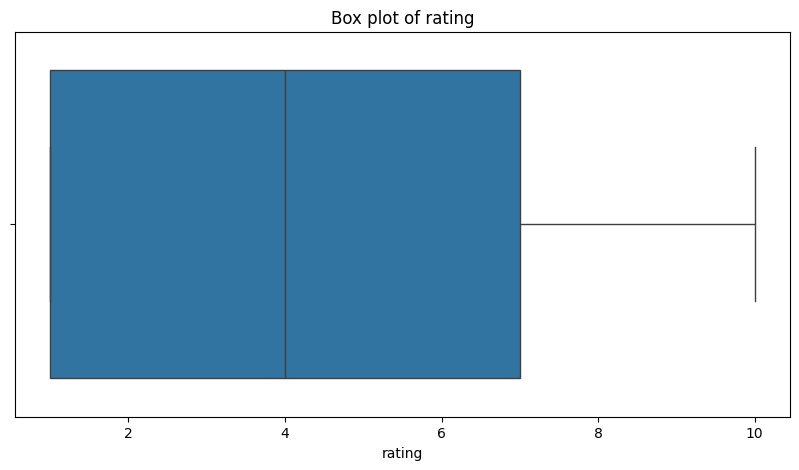

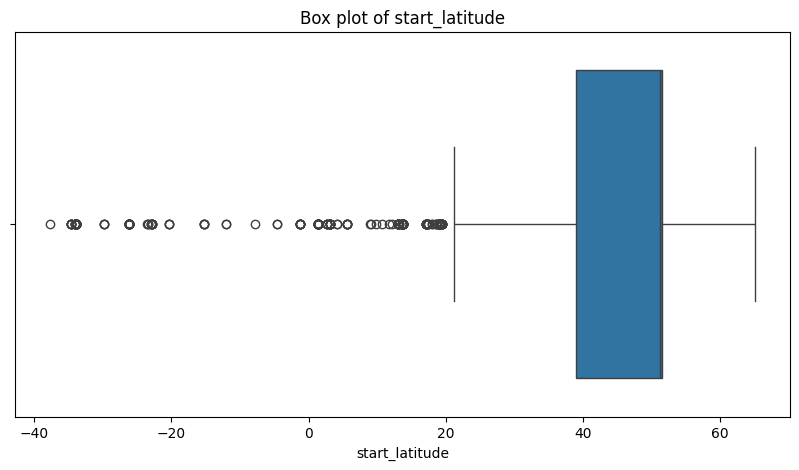

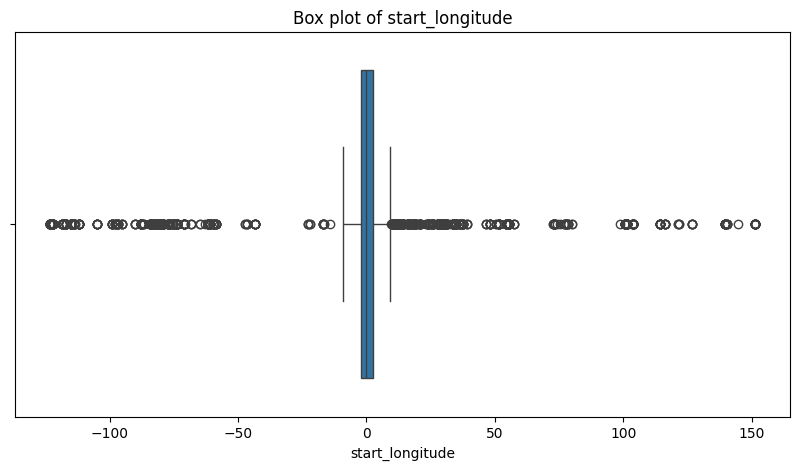

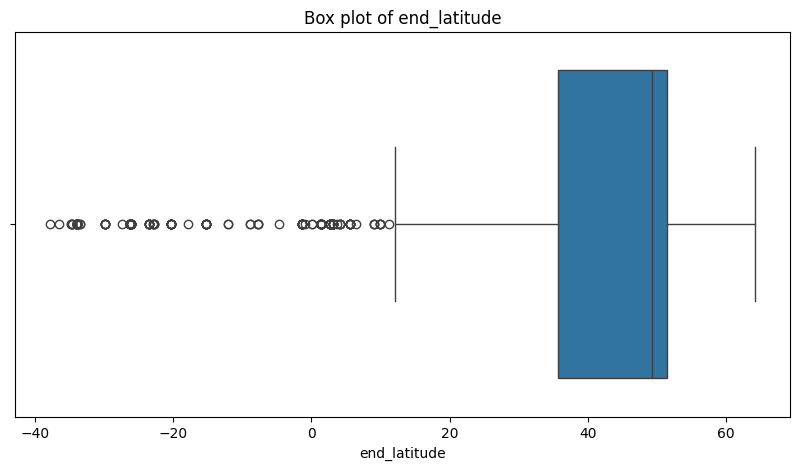

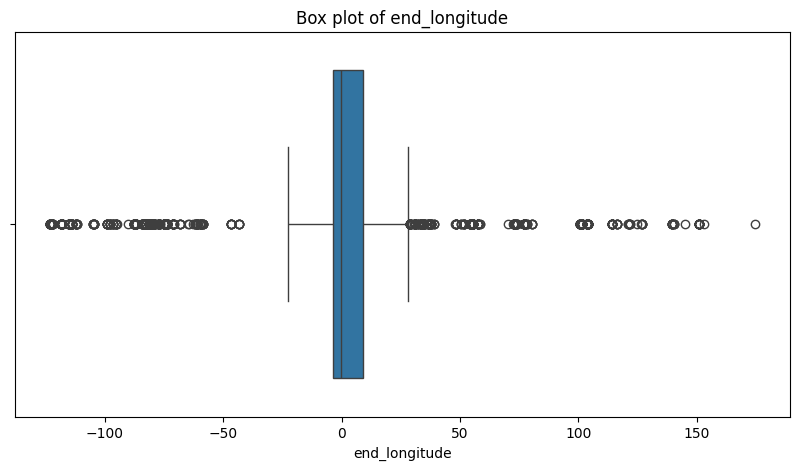

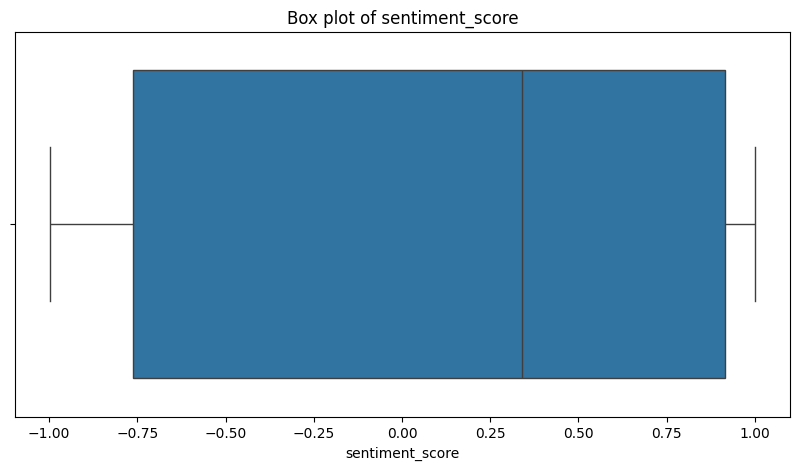

In [201]:
# Visualize distribution of numerical columns to identify outliers
numerical_cols = df.select_dtypes(include=np.number).columns

for col in numerical_cols:
  plt.figure(figsize=(10, 5))
  sns.boxplot(x=df[col])
  plt.title(f'Box plot of {col}')
  plt.savefig(FIG_DIR / f"boxplot_{col}.png", bbox_inches="tight")
  plt.show()
  plt.close()

## Feature Engineering

### Add `country` column

In [202]:
df['start_country'] = df['start_address'].astype(str).apply(lambda x: x.split(',')[-1].strip())
df['end_country'] = df['end_address'].astype(str).apply(lambda x: x.split(',')[-1].strip())

## Data Analysis

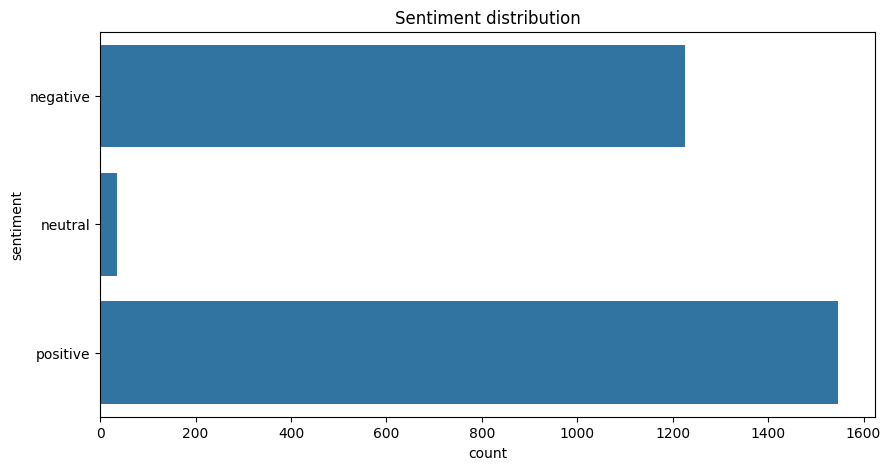

In [203]:
# analyze `sentiment` column
plt.figure(figsize=(10, 5))
sns.countplot(df['sentiment'])
plt.title('Sentiment distribution')
plt.savefig(FIG_DIR / "sentiment_distribution.png", bbox_inches="tight")
plt.show()
plt.close()

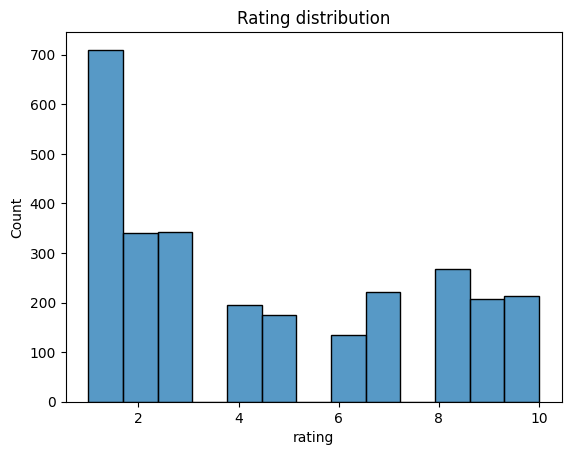

In [204]:
# visualize distribution of `rating`

sns.histplot(df['rating'])
plt.title('Rating distribution')
plt.savefig(FIG_DIR / "rating_distribution.png", bbox_inches="tight")
plt.show()
plt.close()

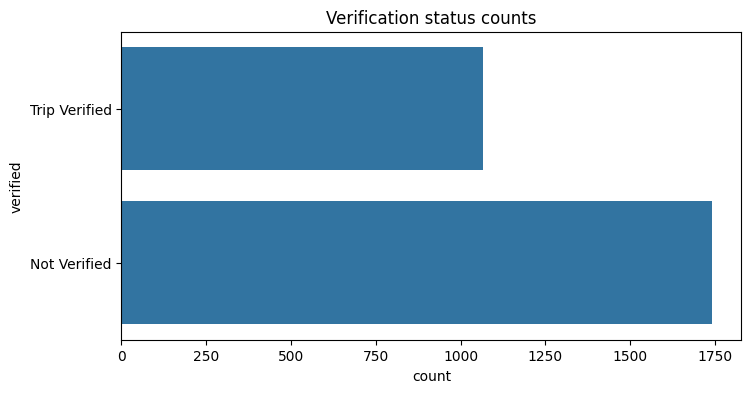

In [205]:
# How many trips are verified?
df['verified'].value_counts()

# Visualize
plt.figure(figsize=(8, 4))
sns.countplot(df['verified'])
plt.title('Verification status counts')
plt.savefig(FIG_DIR / "verification_status.png", bbox_inches="tight")
plt.show()
plt.close()

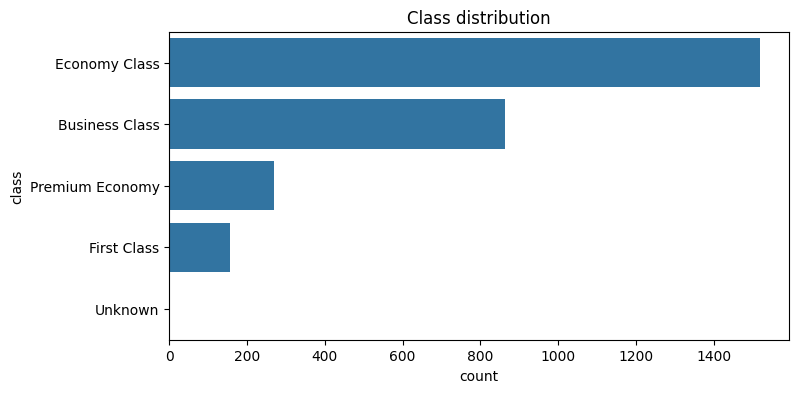

In [206]:
# disrtubution on flying classes
df['class'].value_counts()

# Visualize
plt.figure(figsize=(8, 4))
sns.countplot(df['class'])
plt.title('Class distribution')
plt.savefig(FIG_DIR / "class_distribution.png", bbox_inches="tight")
plt.show()
plt.close()

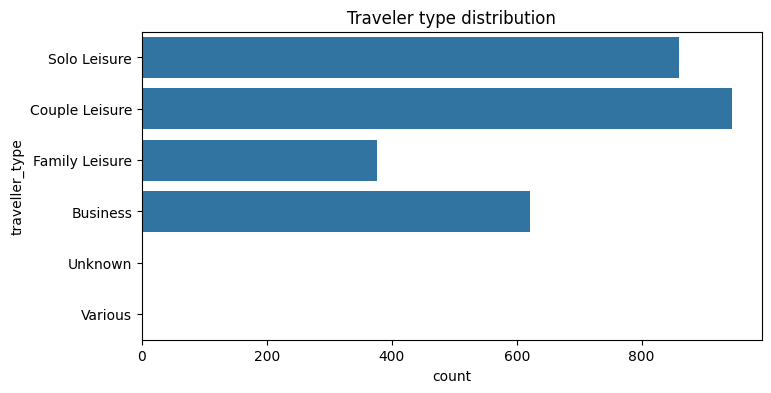

In [207]:
# distribution on traveller types
df['traveller_type'].value_counts()

# Visualize
plt.figure(figsize=(8, 4))
sns.countplot(df['traveller_type'])
plt.title('Traveler type distribution')
plt.savefig(FIG_DIR / "traveler_type_distribution.png", bbox_inches="tight")
plt.show()
plt.close()

**Observation:** Intresting...Couples seem to be higher. are they going to specific countries such as france, italy, etc?

Traveller type: Solo Leisure
end_location
London Heathrow    151
London             103
London Gatwick      39
Glasgow             12
Manchester          11
Name: count, dtype: int64



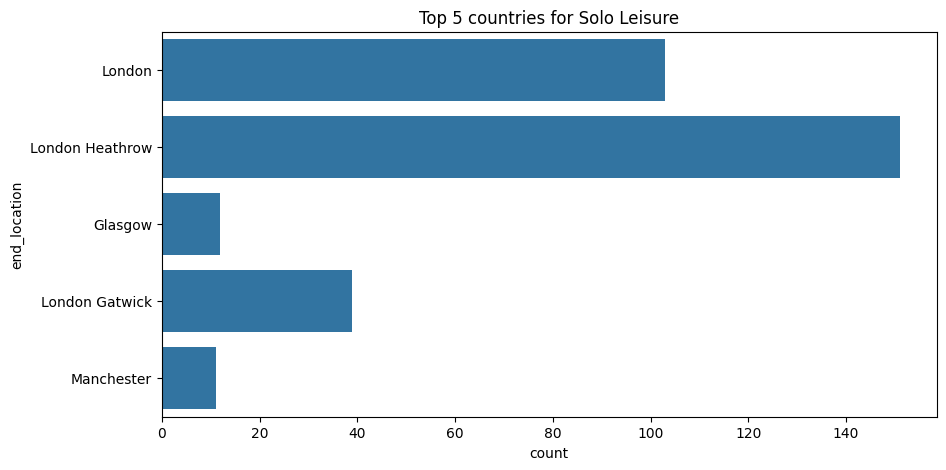

Traveller type: Couple Leisure
end_location
London Heathrow    135
London             126
London Gatwick      74
Cape Town           15
Paris               14
Name: count, dtype: int64



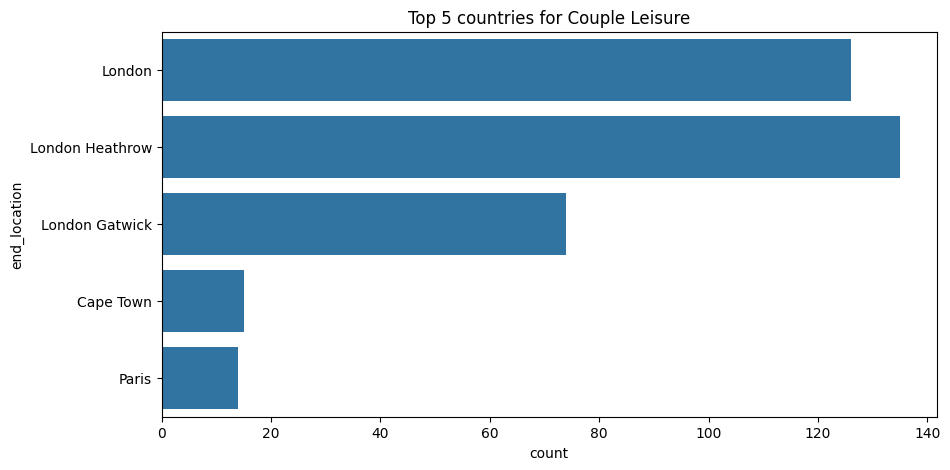

Traveller type: Family Leisure
end_location
London Heathrow    51
London             49
London Gatwick     18
Larnaca             6
Orlando             6
Name: count, dtype: int64



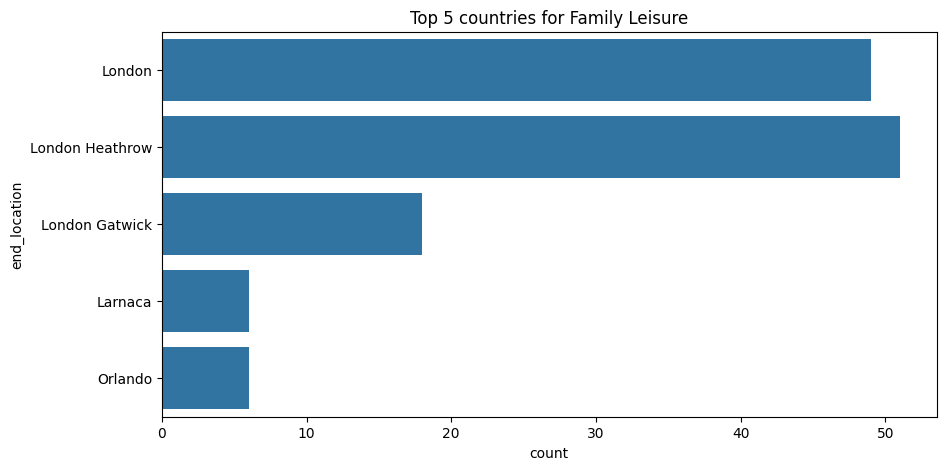

Traveller type: Business
end_location
London             116
London Heathrow     99
London Gatwick      13
Edinburgh            9
Hong Kong            7
Name: count, dtype: int64



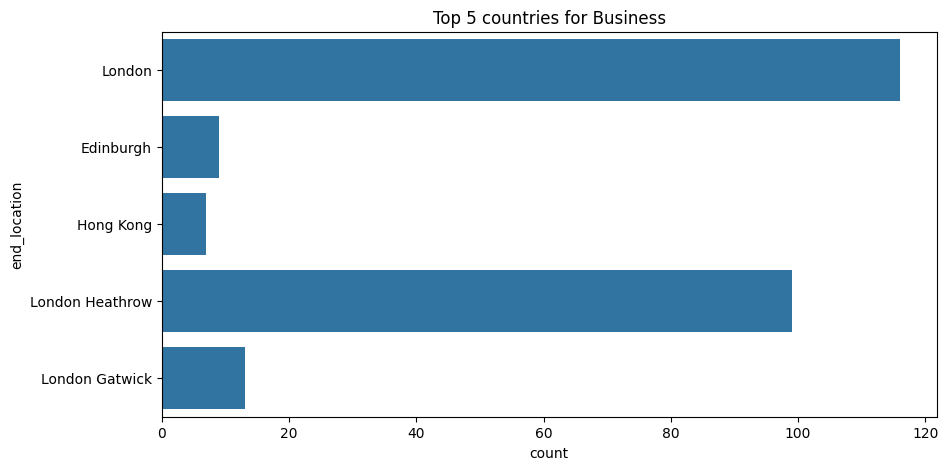

Traveller type: Unknown
end_location
Malaga                                        1
Chicago (IL), O'Hare International Airport    1
Name: count, dtype: int64



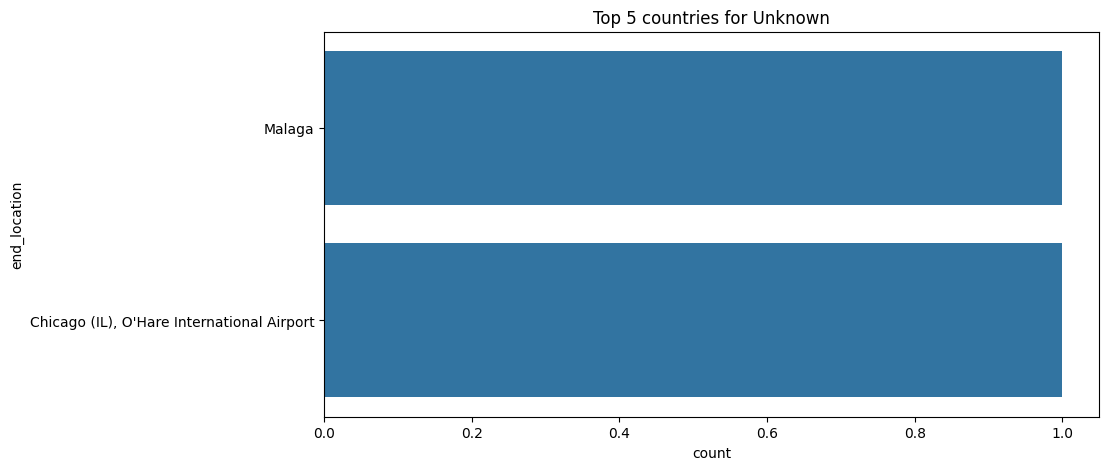

Traveller type: Various
end_location
London Heathrow    1
Name: count, dtype: int64



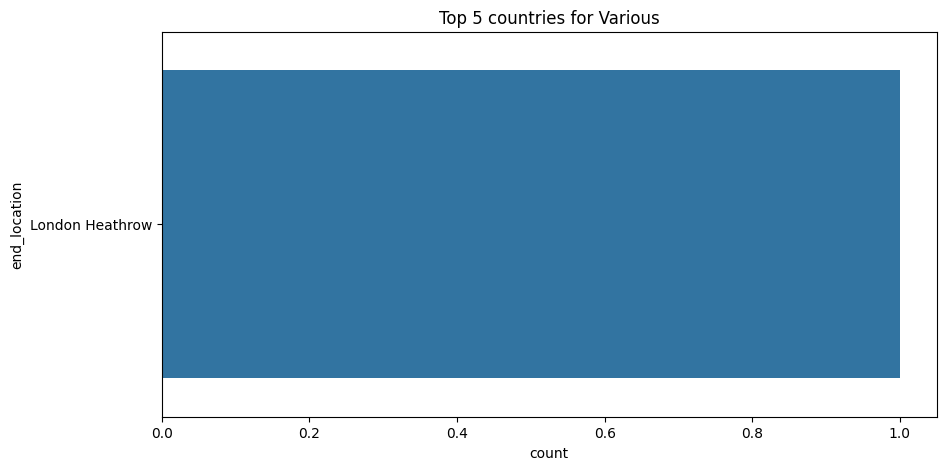

In [208]:
# visualize the top-k countries that each traveller type goes to
traveller_types = df['traveller_type'].unique()

K = 5

for traveller_type in traveller_types:
  top_k_countries = df[df['traveller_type'] == traveller_type]['end_location'].value_counts().head(K)
  print(f'Traveller type: {traveller_type}')
  print(top_k_countries)
  print()
  # Visualize top-k countries
  plt.figure(figsize=(10, 5))
  sns.countplot(df[(df['traveller_type'] == traveller_type) & (df['end_location'].isin(top_k_countries.index))]['end_location'])
  plt.title(f'Top {K} countries for {traveller_type}')
  safe_name = re.sub(r'[^0-9a-zA-Z]+', '_', traveller_type.lower()).strip('_') or 'unknown'
  plt.savefig(FIG_DIR / f"top_end_locations_{safe_name}.png", bbox_inches="tight")
  plt.show()
  plt.close()

**Observations:**
1. All of them are london and london heathrow. are they the same thing? Looking at google yes they both lead to london. does it hold any statistical value?
2. Maybe since this is British Airlines data then it would make sense that the most frequent `end_location` is in UK. We should do the same for start locations

### Investigating Claim 1

In [209]:
df['end_location'].unique()

array(['London', 'Amman', 'Bodrum', 'Ibiza', 'Washington', 'Kalamata',
       'Funchal ', 'Seattle', 'London ', 'Dallas', 'Venice',
       'London City', 'Manchester', 'Nice', 'Sydney', 'Edinburgh',
       'Durban', 'London Heathrow', 'Barcelona', 'Cairo', 'Santorini',
       'Mumbai', 'Larnaca', 'New York', 'Madrid', 'Valencia', 'Glasgow',
       'Malaga ', 'San Francisco', 'Belfast', 'Faro', 'Los Angeles',
       'Zagreb', 'Toronto', 'Denver', 'Hong Kong', 'Malaga',
       'London Gatwick', 'Atlanta', 'Copenhagen', 'Malta', 'Chicago',
       'Amsterdam', 'Lanzarote', 'Marrakech', 'Algiers', 'Munich',
       'Nassau', 'Belfast City', 'Dubrovnik', 'Orlando', 'Dubai',
       'Arlanda Stockholm', 'Tel Aviv', 'Milan Malpensa', 'Istanbul',
       'Las Vegas', 'Singapore', 'Lyon', 'Buenos Aires', 'Vancouver',
       'Johannesburg', 'Male', 'Vienna', 'Alicante', 'Cape Town',
       'Dublin', 'Athens Greece ', 'San francisco', 'Barbados',
       'Frankfurt', 'Delhi', 'Bangkok', 'Cancun', 'Pho

**Observation:** There seems to be a lot of repeated end location. Do they have the same address?

In [210]:
# for every end_location that has the word "london" lower case, check if they have a different end_address
df[df['end_location'].fillna('').str.contains('london', case=False)]['end_address'].unique()

array(['London, Greater London, England, United Kingdom',
       'London (city), Ontario, N6C 0A7, Canada',
       'London Heathrow Airport, Northern Perimeter Road, London Borough of Hillingdon, London, Greater London, England, TW6 2RS, United Kingdom',
       'London Gatwick Airport, Perimeter Road East, Lowfield Heath, Crawley, West Sussex, England, RH6 0JJ, United Kingdom',
       'دبي, الإمارات العربية المتحدة',
       'Tirana, York Road, London Borough of Redbridge, London, Greater London, England, IG1 3AB, United Kingdom',
       'الدوحة, قطر', 'Frankfurt am Main, Hessen, Deutschland',
       'London City Airport, Connaught Road, Silvertown, London Borough of Newham, London, Greater London, England, E16 2FA, United Kingdom'],
      dtype=object)

**Observation:** Wow so there apparently exists a london in canada 🤯 Let's try to automate this

In [211]:
# add a start_country & end_country column
df['start_country'] = df['start_address'].astype(str).apply(lambda x: x.split(',')[-1].strip())
df['end_country'] = df['end_address'].astype(str).apply(lambda x: x.split(',')[-1].strip())
df

,route,rating,verified,review_title,review_content,traveller_type,class,start_location,end_location,layover_route,start_latitude,start_longitude,start_address,end_latitude,end_longitude,end_address,sentiment,sentiment_score,start_country,end_country
0,New Orleans to London,1,Trip Verified,The airline lost my luggage,The airline lost my luggage and was absolutely...,Solo Leisure,Economy Class,New Orleans,London,direct_flight,29.975998,-90.078213,"New Orleans, Orleans Parish, Louisiana, United...",51.507446,-0.127765,"London, Greater London, England, United Kingdom",negative,-0.7990,United States,United Kingdom
1,London to Amman,1,Trip Verified,fully refunded by our travel insurance,"We booked on the BA website, round trip flight...",Couple Leisure,Business Class,London,Amman,direct_flight,51.507446,-0.127765,"London, Greater London, England, United Kingdom",31.951569,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,...",neutral,0.0219,United Kingdom,الأردن
2,Heathrow to Bodrum,2,Trip Verified,no boarding drinks provided,"First time flying with BA business class, neve...",Solo Leisure,Business Class,London Heathrow,Bodrum,direct_flight,51.467739,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",37.034399,27.430651,"Bodrum, Muğla, Ege Bölgesi, Türkiye",negative,-0.7096,United Kingdom,Türkiye
3,Amman to London,4,Not Verified,WiFi didn't work,You can buy sandwiches and crisps but don't ex...,Solo Leisure,Economy Class,Amman,London,direct_flight,31.951569,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,...",51.507446,-0.127765,"London, Greater London, England, United Kingdom",negative,-0.5849,الأردن,United Kingdom
4,London City to Ibiza,7,Trip Verified,stick with economy,This is a two-for-one review covering economy ...,Family Leisure,Business Class,London City,Ibiza,direct_flight,42.953765,-81.229153,"London (city), Ontario, N6C 0A7, Canada",38.974390,1.419746,"Eivissa, Illes Balears, España",positive,0.9789,Canada,España
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2809,Kiev to London,8,Not Verified,British Airways customer review,Flew from Kiev to London on their Airbus 319 i...,Business,Business Class,Kiev,London,direct_flight,50.450034,30.524136,"Київ, Україна",51.507446,-0.127765,"London, Greater London, England, United Kingdom",positive,0.8998,Україна,United Kingdom
2811,London-Vancouver,7,Not Verified,British Airways customer review,LHR to YVR return. Hard earned Avios points tr...,Business,Business Class,London,Vancouver,direct_flight,51.507446,-0.127765,"London, Greater London, England, United Kingdom",49.260872,-123.113952,"Vancouver, Metro Vancouver Regional District, ...",positive,0.9790,United Kingdom,Canada
2812,LHR-ORD,5,Not Verified,British Airways customer review,Club World from LHR-ORD. Busy flight on the ag...,Business,Business Class,London Heathrow,"Chicago (IL), O'Hare International Airport",direct_flight,51.467739,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",41.978081,-87.909182,"O'Hare International Airport, 10000, West Higg...",positive,0.8399,United Kingdom,United States
2813,BOM-LHR,3,Not Verified,British Airways customer review,This review refers to a return trip from India...,Business,Premium Economy,Bombay (Mumbai) - Chhatrapati Shivaji Internat...,London Heathrow,direct_flight,19.090153,72.863713,Chhatrapati Shivaji Maharaj International Airp...,51.467739,-0.458780,"London Heathrow Airport, Northern Perimeter Ro...",negative,-0.5574,India,United Kingdom


### Investigating Claim 2

Traveller type: Solo Leisure
start_location
London Heathrow    175
London             160
London Gatwick      45
Vancouver           14
Singapore           10
Name: count, dtype: int64



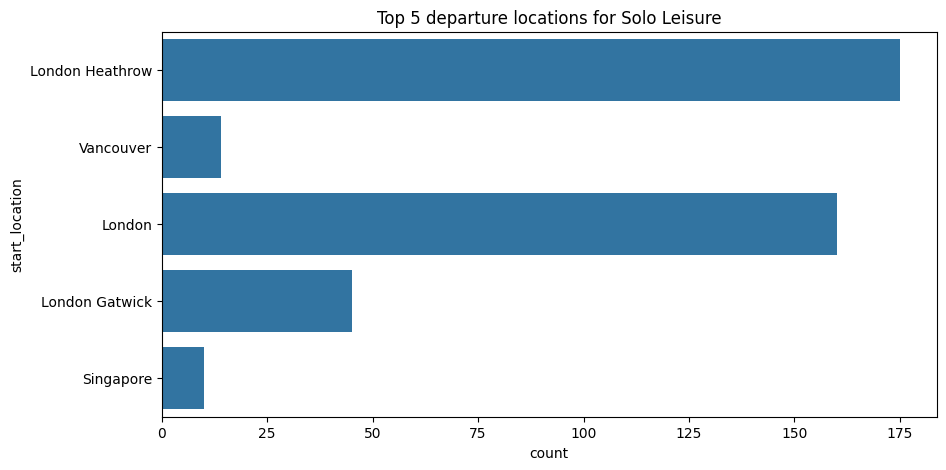

Traveller type: Couple Leisure
start_location
London Heathrow    200
London             133
London Gatwick     106
Glasgow             15
Cape Town           14
Name: count, dtype: int64



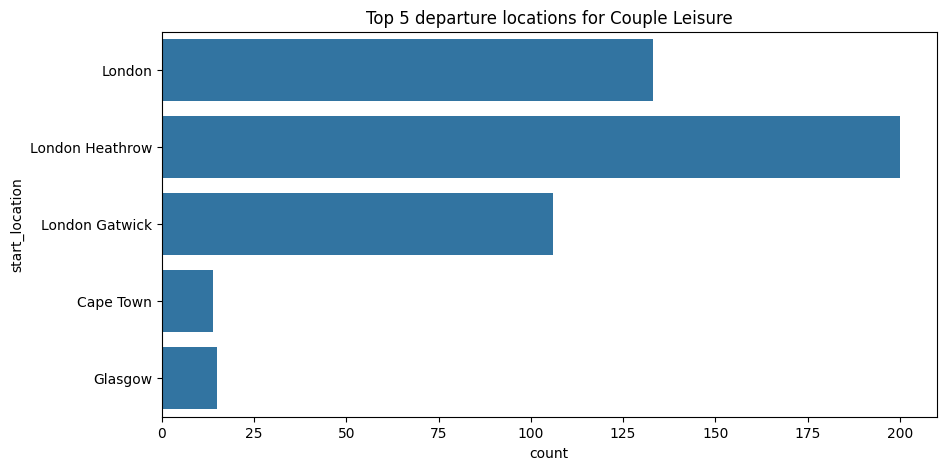

Traveller type: Family Leisure
start_location
London             76
London Heathrow    68
London Gatwick     36
Prague              6
Orlando             5
Name: count, dtype: int64



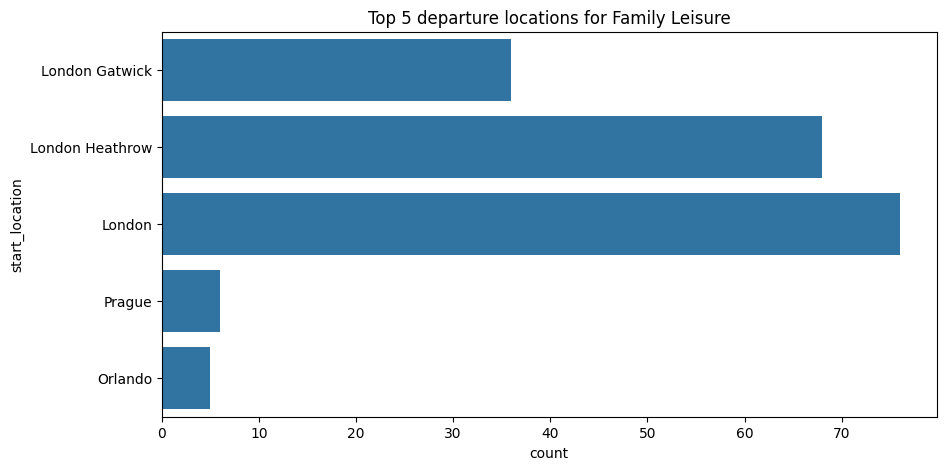

Traveller type: Business
start_location
London Heathrow    138
London             128
London Gatwick      18
Chicago             10
Singapore            9
Name: count, dtype: int64



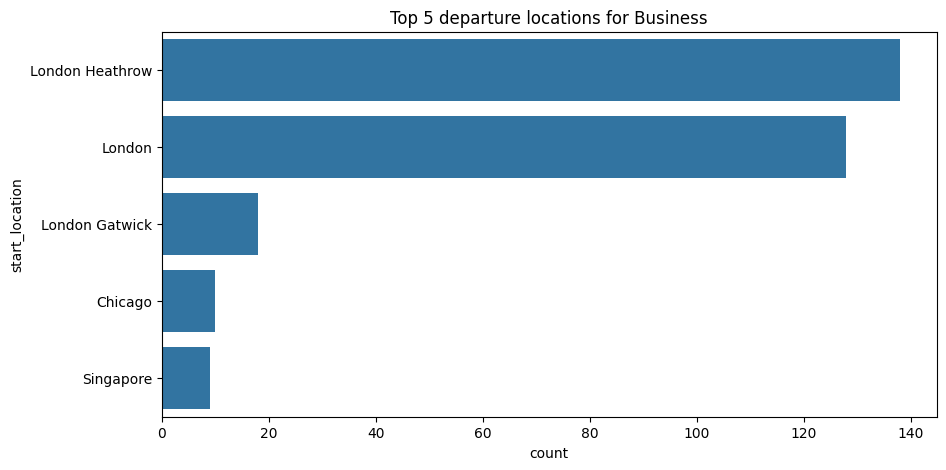

Traveller type: Unknown
start_location
London             1
London Heathrow    1
Name: count, dtype: int64



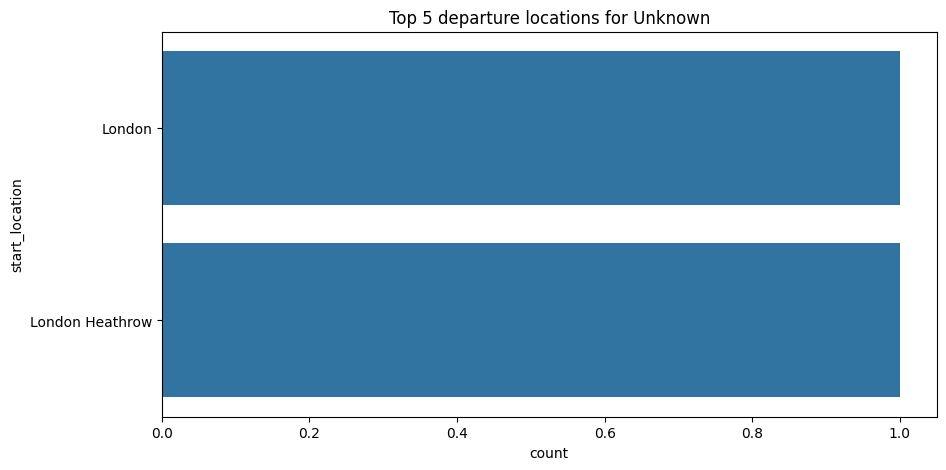

Traveller type: Various
start_location
Bangkok, Suvarnabhumi International    1
Name: count, dtype: int64



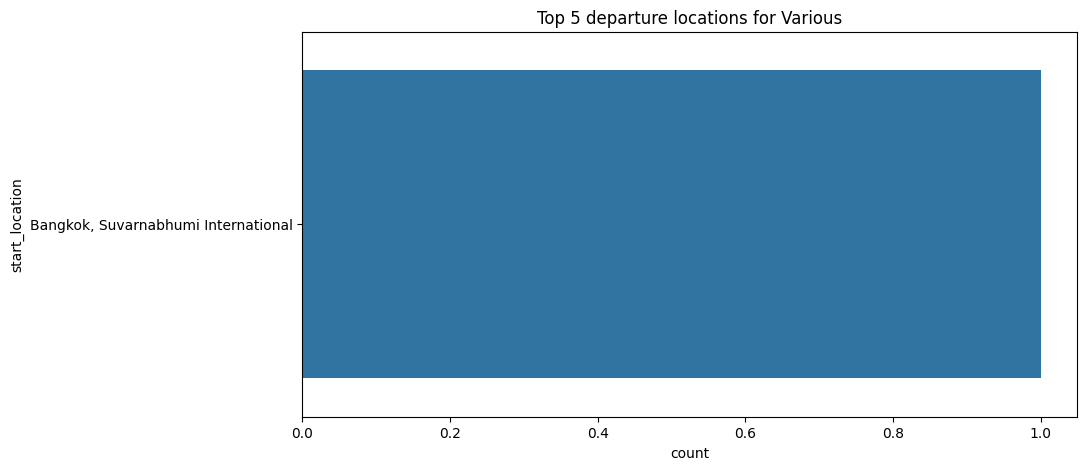

In [212]:
# visualize the top-k countries that each traveller type goes to
traveller_types = df['traveller_type'].unique()

K = 5

for traveller_type in traveller_types:
  top_k_countries = df[df['traveller_type'] == traveller_type]['start_location'].value_counts().head(K)
  print(f'Traveller type: {traveller_type}')
  print(top_k_countries)
  print()
  # Visualize top-k countries
  plt.figure(figsize=(10, 5))
  sns.countplot(df[(df['traveller_type'] == traveller_type) & (df['start_location'].isin(top_k_countries.index))]['start_location'])
  plt.title(f'Top {K} departure locations for {traveller_type}')
  safe_name = re.sub(r'[^0-9a-zA-Z]+', '_', traveller_type.lower()).strip('_') or 'unknown'
  plt.savefig(FIG_DIR / f"top_start_locations_{safe_name}.png", bbox_inches="tight")
  plt.show()
  plt.close()

### Analyze sentiment distribution by flight class

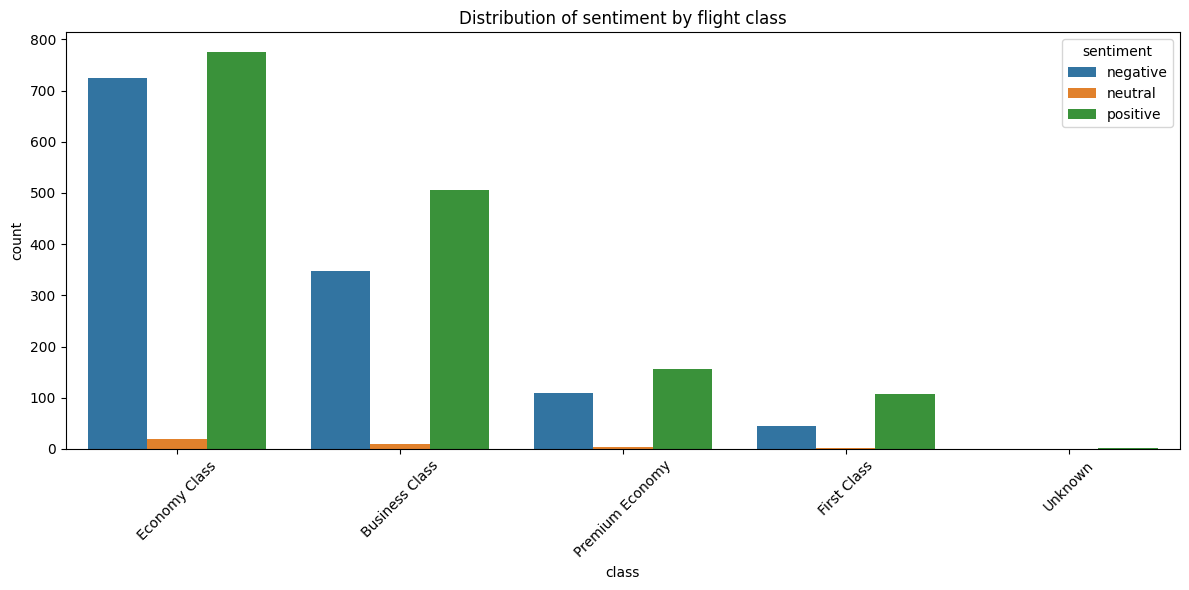

In [213]:
# Explore the relationship between 'sentiment' and 'class'
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='class', hue='sentiment')
plt.title('Distribution of sentiment by flight class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(FIG_DIR / "sentiment_by_class.png", bbox_inches="tight")
plt.show()
plt.close()

### Explore the relationship between `sentiment` and `traveller_type`

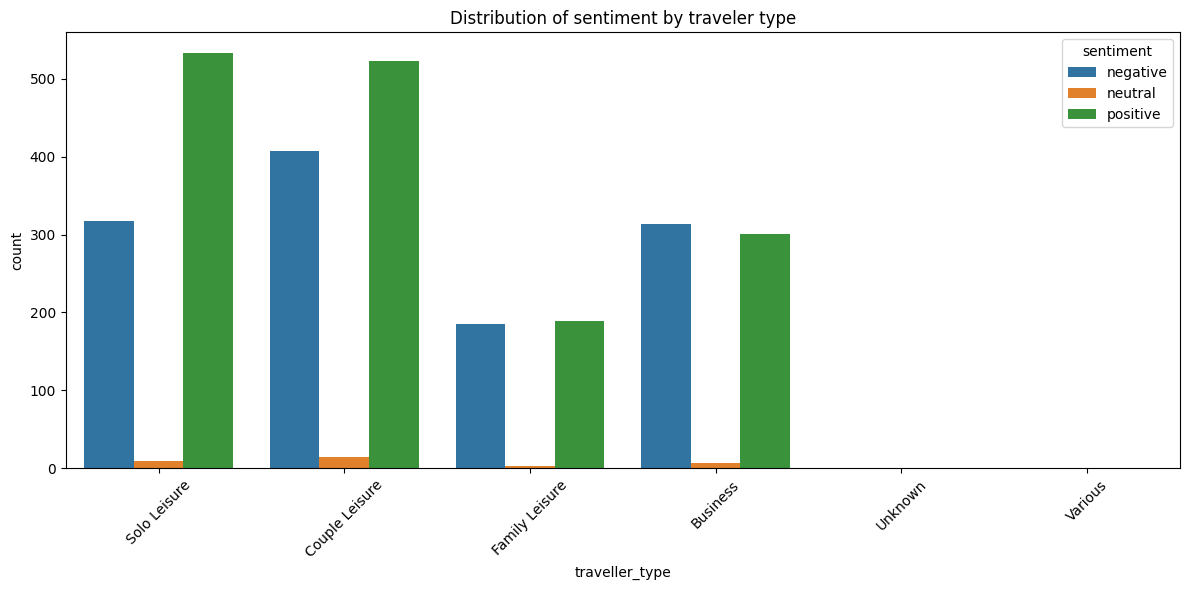

In [214]:
# Explore the relationship between 'sentiment' and 'traveller_type'
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='traveller_type', hue='sentiment')
plt.title('Distribution of sentiment by traveler type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(FIG_DIR / "sentiment_by_traveler_type.png", bbox_inches="tight")
plt.show()
plt.close()

In [215]:
# drop where taraveller_type == 'Unknown'
df = df[df['traveller_type'] != 'Unknown']

# drop where class == 'Unknown'
df = df[df['class'] != 'Unknown']

### What's the correlation between traveler type, class and ratings?

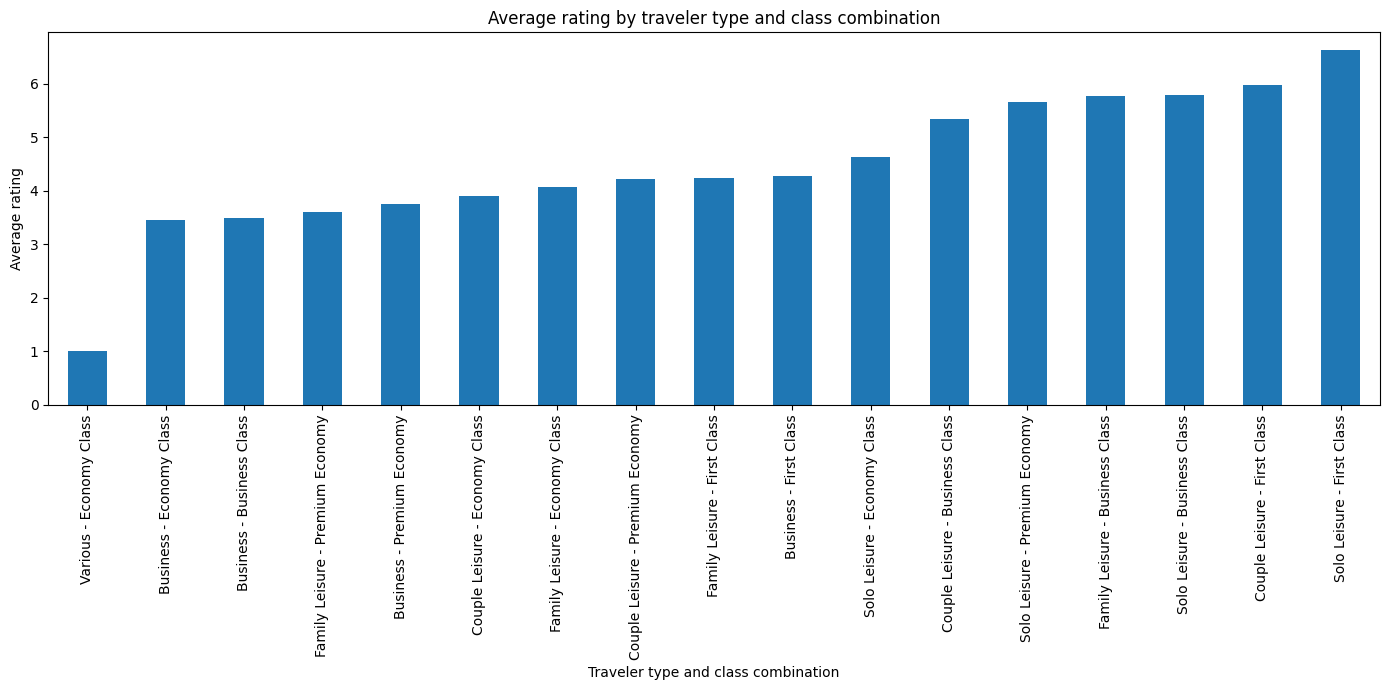

In [216]:
# Create a new column combining 'traveller_type' and 'class' for plotting
df['traveller_class_combo'] = df['traveller_type'] + ' - ' + df['class']

# Calculate the average rating for each combination
avg_rating_combo = df.groupby('traveller_class_combo')['rating'].mean().sort_values()

# Visualize the results
plt.figure(figsize=(14, 7))
avg_rating_combo.plot(kind='bar')
plt.title('Average rating by traveler type and class combination')
plt.xlabel('Traveler type and class combination')
plt.ylabel('Average rating')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(FIG_DIR / "avg_rating_by_traveler_class.png", bbox_inches="tight")
plt.show()
plt.close()

In [217]:
df

,route,rating,verified,review_title,review_content,traveller_type,class,start_location,end_location,layover_route,...,start_longitude,start_address,end_latitude,end_longitude,end_address,sentiment,sentiment_score,start_country,end_country,traveller_class_combo
0,New Orleans to London,1,Trip Verified,The airline lost my luggage,The airline lost my luggage and was absolutely...,Solo Leisure,Economy Class,New Orleans,London,direct_flight,...,-90.078213,"New Orleans, Orleans Parish, Louisiana, United...",51.507446,-0.127765,"London, Greater London, England, United Kingdom",negative,-0.7990,United States,United Kingdom,Solo Leisure - Economy Class
1,London to Amman,1,Trip Verified,fully refunded by our travel insurance,"We booked on the BA website, round trip flight...",Couple Leisure,Business Class,London,Amman,direct_flight,...,-0.127765,"London, Greater London, England, United Kingdom",31.951569,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,...",neutral,0.0219,United Kingdom,الأردن,Couple Leisure - Business Class
2,Heathrow to Bodrum,2,Trip Verified,no boarding drinks provided,"First time flying with BA business class, neve...",Solo Leisure,Business Class,London Heathrow,Bodrum,direct_flight,...,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",37.034399,27.430651,"Bodrum, Muğla, Ege Bölgesi, Türkiye",negative,-0.7096,United Kingdom,Türkiye,Solo Leisure - Business Class
3,Amman to London,4,Not Verified,WiFi didn't work,You can buy sandwiches and crisps but don't ex...,Solo Leisure,Economy Class,Amman,London,direct_flight,...,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,...",51.507446,-0.127765,"London, Greater London, England, United Kingdom",negative,-0.5849,الأردن,United Kingdom,Solo Leisure - Economy Class
4,London City to Ibiza,7,Trip Verified,stick with economy,This is a two-for-one review covering economy ...,Family Leisure,Business Class,London City,Ibiza,direct_flight,...,-81.229153,"London (city), Ontario, N6C 0A7, Canada",38.974390,1.419746,"Eivissa, Illes Balears, España",positive,0.9789,Canada,España,Family Leisure - Business Class
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2809,Kiev to London,8,Not Verified,British Airways customer review,Flew from Kiev to London on their Airbus 319 i...,Business,Business Class,Kiev,London,direct_flight,...,30.524136,"Київ, Україна",51.507446,-0.127765,"London, Greater London, England, United Kingdom",positive,0.8998,Україна,United Kingdom,Business - Business Class
2811,London-Vancouver,7,Not Verified,British Airways customer review,LHR to YVR return. Hard earned Avios points tr...,Business,Business Class,London,Vancouver,direct_flight,...,-0.127765,"London, Greater London, England, United Kingdom",49.260872,-123.113952,"Vancouver, Metro Vancouver Regional District, ...",positive,0.9790,United Kingdom,Canada,Business - Business Class
2812,LHR-ORD,5,Not Verified,British Airways customer review,Club World from LHR-ORD. Busy flight on the ag...,Business,Business Class,London Heathrow,"Chicago (IL), O'Hare International Airport",direct_flight,...,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",41.978081,-87.909182,"O'Hare International Airport, 10000, West Higg...",positive,0.8399,United Kingdom,United States,Business - Business Class
2813,BOM-LHR,3,Not Verified,British Airways customer review,This review refers to a return trip from India...,Business,Premium Economy,Bombay (Mumbai) - Chhatrapati Shivaji Internat...,London Heathrow,direct_flight,...,72.863713,Chhatrapati Shivaji Maharaj International Airp...,51.467739,-0.458780,"London Heathrow Airport, Northern Perimeter Ro...",negative,-0.5574,India,United Kingdom,Business - Premium Economy


## Encoding

In [218]:
# ordinal_encoding_columns = ['route', 'start_location', 'end_location']
# one_hot_encoding_columns = ['class', 'traveller_type', 'verified', 'sentiment']
#
# # Encode
# le = LabelEncoder()
# for col in ordinal_encoding_columns:
#   df[col] = le.fit_transform(df[col])
#
# ohe = OneHotEncoder()
# for col in one_hot_encoding_columns:
#   df_encoded = pd.DataFrame(ohe.fit_transform(df[[col]]).toarray(), columns=[f'{col}_{cat}' for cat in ohe.categories_[0]])
#   df = pd.concat([df, df_encoded], axis=1)
#   df = df.drop(columns=[col])
#
# df

### Let's see the correlation between all non string columns

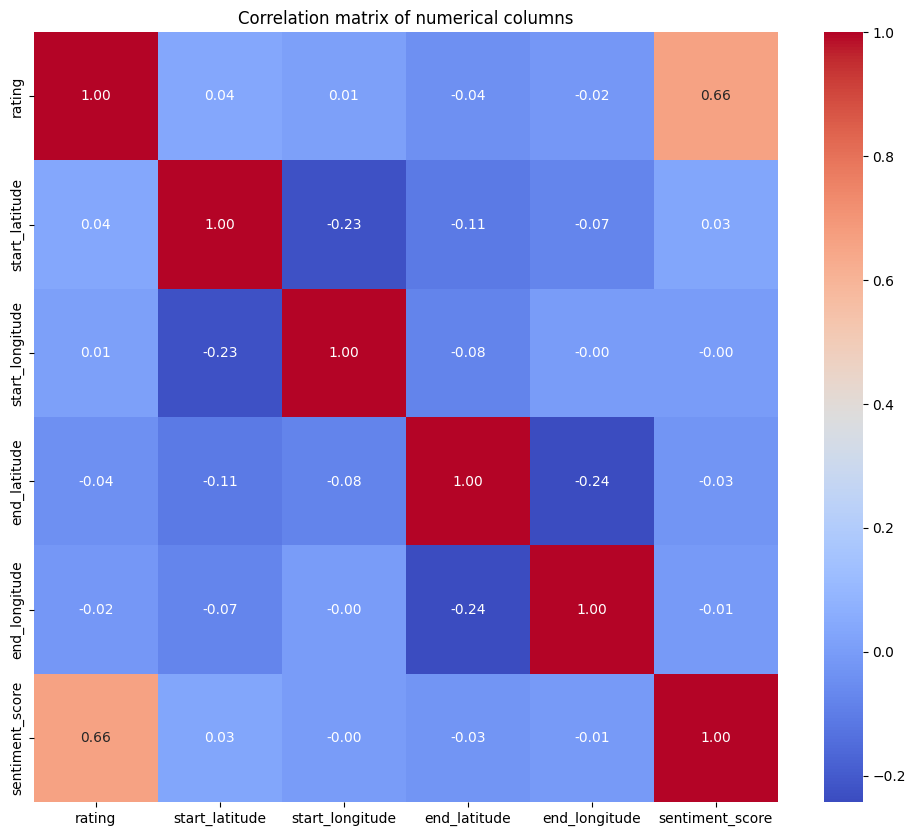

In [219]:
# Select only numerical columns
numerical_df = df.select_dtypes(include=np.number)

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation matrix of numerical columns')
plt.savefig(FIG_DIR / "correlation_heatmap.png", bbox_inches="tight")
plt.show()
plt.close()

In [220]:
# Add is_satisfied when rating >= 5
df['is_satisfied'] = df['rating'].apply(lambda x: 1 if x >= 5 else 0)
df

,route,rating,verified,review_title,review_content,traveller_type,class,start_location,end_location,layover_route,...,start_address,end_latitude,end_longitude,end_address,sentiment,sentiment_score,start_country,end_country,traveller_class_combo,is_satisfied
0,New Orleans to London,1,Trip Verified,The airline lost my luggage,The airline lost my luggage and was absolutely...,Solo Leisure,Economy Class,New Orleans,London,direct_flight,...,"New Orleans, Orleans Parish, Louisiana, United...",51.507446,-0.127765,"London, Greater London, England, United Kingdom",negative,-0.7990,United States,United Kingdom,Solo Leisure - Economy Class,0
1,London to Amman,1,Trip Verified,fully refunded by our travel insurance,"We booked on the BA website, round trip flight...",Couple Leisure,Business Class,London,Amman,direct_flight,...,"London, Greater London, England, United Kingdom",31.951569,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,...",neutral,0.0219,United Kingdom,الأردن,Couple Leisure - Business Class,0
2,Heathrow to Bodrum,2,Trip Verified,no boarding drinks provided,"First time flying with BA business class, neve...",Solo Leisure,Business Class,London Heathrow,Bodrum,direct_flight,...,"London Heathrow Airport, The Beacon Roundabout...",37.034399,27.430651,"Bodrum, Muğla, Ege Bölgesi, Türkiye",negative,-0.7096,United Kingdom,Türkiye,Solo Leisure - Business Class,0
3,Amman to London,4,Not Verified,WiFi didn't work,You can buy sandwiches and crisps but don't ex...,Solo Leisure,Economy Class,Amman,London,direct_flight,...,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,...",51.507446,-0.127765,"London, Greater London, England, United Kingdom",negative,-0.5849,الأردن,United Kingdom,Solo Leisure - Economy Class,0
4,London City to Ibiza,7,Trip Verified,stick with economy,This is a two-for-one review covering economy ...,Family Leisure,Business Class,London City,Ibiza,direct_flight,...,"London (city), Ontario, N6C 0A7, Canada",38.974390,1.419746,"Eivissa, Illes Balears, España",positive,0.9789,Canada,España,Family Leisure - Business Class,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2809,Kiev to London,8,Not Verified,British Airways customer review,Flew from Kiev to London on their Airbus 319 i...,Business,Business Class,Kiev,London,direct_flight,...,"Київ, Україна",51.507446,-0.127765,"London, Greater London, England, United Kingdom",positive,0.8998,Україна,United Kingdom,Business - Business Class,1
2811,London-Vancouver,7,Not Verified,British Airways customer review,LHR to YVR return. Hard earned Avios points tr...,Business,Business Class,London,Vancouver,direct_flight,...,"London, Greater London, England, United Kingdom",49.260872,-123.113952,"Vancouver, Metro Vancouver Regional District, ...",positive,0.9790,United Kingdom,Canada,Business - Business Class,1
2812,LHR-ORD,5,Not Verified,British Airways customer review,Club World from LHR-ORD. Busy flight on the ag...,Business,Business Class,London Heathrow,"Chicago (IL), O'Hare International Airport",direct_flight,...,"London Heathrow Airport, The Beacon Roundabout...",41.978081,-87.909182,"O'Hare International Airport, 10000, West Higg...",positive,0.8399,United Kingdom,United States,Business - Business Class,1
2813,BOM-LHR,3,Not Verified,British Airways customer review,This review refers to a return trip from India...,Business,Premium Economy,Bombay (Mumbai) - Chhatrapati Shivaji Internat...,London Heathrow,direct_flight,...,Chhatrapati Shivaji Maharaj International Airp...,51.467739,-0.458780,"London Heathrow Airport, Northern Perimeter Ro...",negative,-0.5574,India,United Kingdom,Business - Premium Economy,0


In [221]:
# detect and delete duplicates
print(f"Number of duplicates: {df.duplicated().sum()}")
df = df.drop_duplicates()

Number of duplicates: 0


## Save Final Dataset

In [222]:
output_filename = "data/cleaned/AirlineScrappedReview_Cleaned_Enhanced.csv"
df.to_csv(output_filename, index=False)